# HW3 Image Classification
## We strongly recommend that you run with [Kaggle](https://www.kaggle.com/t/86ca241732c04da99aca6490080bae73) for this homework

If you have any questions, please contact the TAs via TA hours, NTU COOL, or email to mlta-2023-spring@googlegroups.com

# Check GPU Type

In [1]:
!nvidia-smi

Wed Apr 12 22:11:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.89.02    Driver Version: 525.89.02    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   36C    P0    43W / 170W |    696MiB / 12288MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Get Data
Notes: if the links are dead, you can download the data directly from Kaggle and upload it to the workspace, or you can use the Kaggle API to directly download the data into colab.


In [2]:
# Download Link
# Link 1 (Dropbox): https://www.dropbox.com/s/up5q1gthsz3v0dq/food-11.zip?dl=0
# Link 2 (Google Drive): https://drive.google.com/file/d/1tbGNwk1yGoCBdu4Gi_Cia7EJ9OhubYD9/view?usp=share_link
# Link 3: Kaggle Competition.

# (1) dropbox link
# !wget -O food11.zip https://www.dropbox.com/s/up5q1gthsz3v0dq/food-11.zip?dl=0

# (2) google drive link
# !pip install gdown --upgrade
# !gdown --id '1tbGNwk1yGoCBdu4Gi_Cia7EJ9OhubYD9' --output food11.zip

In [3]:
# ! unzip food11.zip

# Import Packages

In [4]:
# Define your log filename
_exp_name = "sample"

In [5]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset
# Pretrained model
from torchvision.models import resnet34, resnet50, vgg16, densenet121, alexnet, squeezenet1_0
# This is for the progress bar.
from tqdm.auto import tqdm
import random
# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter
# K-fold cross validation and boosting
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostClassifier

In [6]:
myseed = 3407  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# Transforms
Torchvision provides lots of useful utilities for image preprocessing, data *wrapping* as well as data augmentation.

Please refer to PyTorch official website for details about different transforms.

In [7]:
# Normally, We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# However, it is also possible to use augmentation in the testing phase.
# You may use train_tfm to produce a variety of images and then test using ensemble methods

train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # You may add some transforms here.
    
    transforms.RandomChoice(transforms=[
        # Apply TrivialAugmentWide data augmentation method
        transforms.TrivialAugmentWide(),

        # Return original image
        transforms.Lambda(lambda x: x),
    ],
                            p=[0.95, 0.05]),

    # ToTensor() should be the last one of the transfo·rms.
    transforms.ToTensor(),
])

# Q1. Augmentation Implementation Visualization

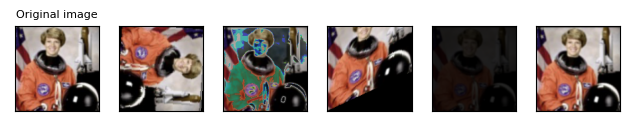

In [8]:
# I want to show you an example code of Q1. Augmentation Implementation that visualizes the effects of different image transformations.
import matplotlib.pyplot as plt

plt.rcParams["savefig.bbox"] = 'tight'

# You can change the file path to match your image
orig_img = Image.open('Q1/assets/astronaut.jpg')


def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

# Create a list of five transformed images from the original image using the train_tfm function
demo = [train_tfm(orig_img) for i in range(5)]

# Convert the transformed images from tensors to PIL images
pil_img_demo = [Image.fromarray(np.moveaxis(img.numpy()*255, 0, -1).astype(np.uint8)) for img in demo]

# Plot the transformed images using the plot function
plot(pil_img_demo) 

# Datasets
The data is labelled by the name, so we load images and label while calling '__getitem__'

In [9]:
class FoodDataset(Dataset):

    def __init__(self,path,tfm=test_tfm,files = None):
        super(FoodDataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files
            
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        
        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 # test has no label
            
        return im,label

# Model

In [10]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024), # before:（512*4*4）
            nn.ReLU(),
            nn.Dropout(p=0.15),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.15),
            nn.Linear(512, 11)
        )
        

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

class ResNet34(nn.Module):
    def __init__(self):
        super(ResNet34, self).__init__()
        self.model = resnet34(weights=None)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, 11)
        self.model.num_classes = 11
        
    def forward(self, x):
        return self.model(x)
    
class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        self.model = resnet50(weights=None)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, 11)
        self.model.num_classes = 11
        
    
    def forward(self, x):
        return self.model(x)

    
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.model = vgg16(weights=None)
        num_features = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(num_features, 11)
        self.model.num_classes = 11

    def forward(self, x):
        return self.model(x)


class DenseNet121(nn.Module):
    def __init__(self):
        super(DenseNet121, self).__init__()
        self.model = densenet121(weights=None)
        num_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(num_features, 11)
        self.model.num_classes = 11

    def forward(self, x):
        x = self.model(x)
        return x
    

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.model = alexnet(weights=None)
        num_features = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(num_features, 11)
        self.model.num_classes = 11

    def forward(self, x):
        x = self.model(x)
        return x
    
    
class SqueezeNet(nn.Module):
    def __init__(self):
        super(SqueezeNet, self).__init__()
        self.model = squeezenet1_0(weights=None)
        # (1): Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
        num_features = self.model.classifier[1].in_channels
        self.model.classifier[1] = nn.Conv2d(num_features, 11, kernel_size=(1,1), stride=(1,1))
        self.model.num_classes = 11
        
    def forward(self, x):
        x = self.model(x)
        return x

    
class EnsembleModel(nn.Module):
    def __init__(self, base_models):
        super(EnsembleModel, self).__init__()
        self.base_models = nn.ModuleList(base_models)
#         self.classifier = nn.Linear(len(base_models) * 11, 11)

    def forward(self, x):
        outputs = [model(x) for model in self.base_models]
#         outputs = torch.cat(outputs, dim=1)
#         outputs = self.classifier(outputs)
#         return outputs

        outputs = torch.stack(outputs)
        outputs = torch.mean(outputs, dim=0)
        return outputs

# Configurations

In [11]:
# "cuda" only when GPUs are available.
# If you use apple chip (mac), you can change "cpu" to "mps"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.

model = Classifier().to(device)

Resume = False
if Resume:
    model.load_state_dict(torch.load(f"{_exp_name}_best.ckpt", map_location='cuda'))

# The number of batch size.
batch_size = 64

# The number of training epochs.
n_epochs = 300

# If no improvement in 'patience' epochs, early stop.
patience = 30

# For the classification task, we use cross-entropy as the measurement of performance.
# criterion = nn.CrossEntropyLoss()
# Label Smoothing Cross Entropy Loss
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5) # 3e-4

# Create a learning rate scheduler that reduces the learning rate when the metric stops improving
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.8, patience=patience/2, threshold=0.05)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-8)

# Dataloader

In [12]:
# # Construct train and valid datasets.
# # The argument "loader" tells how torchvision reads the data.
train_set = FoodDataset("./train", tfm=train_tfm)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = FoodDataset("./valid", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

# Start Training

In [13]:
# # Create a SummaryWriter object to write data to TensorBoard and the results are stored in ./runs folder
# writer = SummaryWriter()

# # Initialize trackers, these are not parameters and should not be changed
# stale = 0
# best_acc = 0

# for epoch in range(n_epochs):

#     # ---------- Training ----------
#     # Make sure the model is in train mode before training.
#     model.train()

#     # These are used to record information in training.
#     train_loss = []
#     train_accs = []

#     for batch in tqdm(train_loader):

#         # A batch consists of image data and corresponding labels.
#         imgs, labels = batch
        
#         #imgs = imgs.half()  # image.dtype: torch.float32 => torch.float16
#         #print(imgs.dtype)
#         #print(imgs.shape,labels.shape)

#         # Forward the data. (Make sure data and model are on the same device.)
#         logits = model(imgs.to(device))

#         # Calculate the cross-entropy loss.
#         # We don't need to apply softmax before computing cross-entropy as it is done automatically.
#         loss = criterion(logits, labels.to(device))

#         # Gradients stored in the parameters in the previous step should be cleared out first.
#         optimizer.zero_grad()

#         # Compute the gradients for parameters.
#         loss.backward()

#         # Clip the gradient norms for stable training.
#         grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

#         # Update the parameters with computed gradients.
#         optimizer.step()

#         # Compute the accuracy for current batch.
#         acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

#         # Record the loss and accuracy.
#         train_loss.append(loss.item())
#         train_accs.append(acc)
        
#     train_loss = sum(train_loss) / len(train_loss)
#     train_acc = sum(train_accs) / len(train_accs)

#     # Print the information.
#     print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

#     # ---------- Validation ----------
#     # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
#     model.eval()

#     # These are used to record information in validation.
#     valid_loss = []
#     valid_accs = []

#     # Iterate the validation set by batches.
#     for batch in tqdm(valid_loader):

#         # A batch consists of image data and corresponding labels.
#         imgs, labels = batch
#         #imgs = imgs.half()

#         # We don't need gradient in validation.
#         # Using torch.no_grad() accelerates the forward process.
#         with torch.no_grad():
#             logits = model(imgs.to(device))

#         # We can still compute the loss (but not the gradient).
#         loss = criterion(logits, labels.to(device))

#         # Compute the accuracy for current batch.
#         acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

#         # Record the loss and accuracy.
#         valid_loss.append(loss.item())
#         valid_accs.append(acc)
#         #break

#     # The average loss and accuracy for entire validation set is the average of the recorded values.
#     valid_loss = sum(valid_loss) / len(valid_loss)
#     valid_acc = sum(valid_accs) / len(valid_accs)

#     # Print the information.
#     #print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

#     writer.add_scalar('Acc/train', train_acc, epoch)
#     writer.add_scalar('Acc/valid', valid_acc, epoch)
#     writer.add_scalar('lr', optimizer.state_dict()['param_groups'][0]['lr'], epoch)

#     # Update logs
#     if valid_acc > best_acc:
#         with open(f"./{_exp_name}_log.txt","a"):
#             print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
#     else:
#         with open(f"./{_exp_name}_log.txt","a"):
#             print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


#     # Save models
#     if valid_acc > best_acc:
#         print(f"Best model found at epoch {epoch}, saving model")
#         torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
#         best_acc = valid_acc
#         stale = 0
#     else:
#         stale += 1
#         if stale > patience:
#             print(f"No improvment {patience} consecutive epochs, early stopping")
#             break
            
#     # Update learning rate based on the best_acc so far
#     scheduler.step(best_acc)

## Cross validation
You can implement cross validation entirely using the cross_val_score in sklearn.model_selection, but I'll show you another way to implement it here.

In [ ]:
def k_fold(dataset, k=5, tb=False):
    '''Perform k-fold cross-validation on the dataset and optionally use tensorboard to log data

    Parameters:
        dataset: a torch.utils.data.Dataset object
        k (int): an integer that specifies the number of folds for cross-validation
        tb (bool): a boolean that indicates whether to use tensorboard to log data
    '''
    # Set the number of folds for cross-validation
    k = k
    # Create a KFold object to split the dataset into k subsets
    kf = KFold(n_splits=k, shuffle=True) # shuffle: default=False

    models = [Classifier] * k
    for fold, (train_idx, valid_idx) in enumerate(kf.split(dataset)):
        model = models[fold]().to(device)
        # Print the current fold number
        print(f"Fold {fold+1}, model: {models[fold].__name__}")

        # Print the indices of the train and valid subsets
        print("Train Index: ", train_idx)
        print("Valid Index: ", valid_idx)
        
        
        
        optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.8, patience=patience/2, threshold=0.05)
        
        # Create a subset of the dataset based on the train indices
        train_set = Subset(dataset, train_idx)
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
        # Create a subset of the dataset based on the valid indices
        valid_set = Subset(dataset, valid_idx)
        valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)    

        # Initialize a list to store the validation accuracies of each fold
        val_accs = []
    
        # ---------- Use the same training loop as in the previous section ----------
        if tb:
            # Create a SummaryWriter object to write data to TensorBoard and the results are stored in ./runs folder
            writer = SummaryWriter()
        
        # Initialize trackers, these are not parameters and should not be changed
        stale = 0
        best_acc = 0

        for epoch in range(n_epochs):

            # ---------- Training ----------
            # Make sure the model is in train mode before training.
            model.train()

            # These are used to record information in training.
            train_loss = []
            train_accs = []

            for batch in tqdm(train_loader):

                # A batch consists of image data and corresponding labels.
                imgs, labels = batch

                #imgs = imgs.half()  # image.dtype: torch.float32 => torch.float16
                #print(imgs.dtype)
                #print(imgs.shape,labels.shape)

                # Forward the data. (Make sure data and model are on the same device.)
                logits = model(imgs.to(device))

                # Calculate the cross-entropy loss.
                # We don't need to apply softmax before computing cross-entropy as it is done automatically.
                loss = criterion(logits, labels.to(device))

                # Gradients stored in the parameters in the previous step should be cleared out first.
                optimizer.zero_grad()

                # Compute the gradients for parameters.
                loss.backward()

                # Clip the gradient norms for stable training.
                grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

                # Update the parameters with computed gradients.
                optimizer.step()

                # Compute the accuracy for current batch.
                acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

                # Record the loss and accuracy.
                train_loss.append(loss.item())
                train_accs.append(acc)

            train_loss = sum(train_loss) / len(train_loss)
            train_acc = sum(train_accs) / len(train_accs)

            # Print the information.
            print(f"Fold {fold+1}: [ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

            # ---------- Validation ----------
            # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
            model.eval()

            # These are used to record information in validation.
            valid_loss = []
            valid_accs = []

            # Iterate the validation set by batches.
            for batch in tqdm(valid_loader):

                # A batch consists of image data and corresponding labels.
                imgs, labels = batch
                #imgs = imgs.half()

                # We don't need gradient in validation.
                # Using torch.no_grad() accelerates the forward process.
                with torch.no_grad():
                    logits = model(imgs.to(device))

                # We can still compute the loss (but not the gradient).
                loss = criterion(logits, labels.to(device))

                # Compute the accuracy for current batch.
                acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

                # Record the loss and accuracy.
                valid_loss.append(loss.item())
                valid_accs.append(acc)
                #break

            # The average loss and accuracy for entire validation set is the average of the recorded values.
            valid_loss = sum(valid_loss) / len(valid_loss)
            valid_acc = sum(valid_accs) / len(valid_accs)

            # Print the information.
            #print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
            if tb:
                writer.add_scalar('Acc/train', train_acc, epoch)
                writer.add_scalar('Acc/valid', valid_acc, epoch)
                writer.add_scalar('lr', optimizer.state_dict()['param_groups'][0]['lr'], epoch)

            # Update logs
            if valid_acc > best_acc:
                with open(f"./{_exp_name}_log.txt","a"):
                    print(f"Fold {fold+1}: [ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
            else:
                with open(f"./{_exp_name}_log.txt","a"):
                    print(f"Fold {fold+1}: [ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


            # Save models
            if valid_acc > best_acc:
                print(f"Best model found at epoch {epoch}, saving model")
                torch.save(model.state_dict(), f"{_exp_name}_fold{fold+1}_{models[fold].__name__}_label_smoothing_300_best.ckpt") # only save best to prevent output memory exceed error
                best_acc = valid_acc
                stale = 0
            else:
                stale += 1
                if stale > patience:
                    print(f"No improvment {patience} consecutive epochs, early stopping")
                    break

            # Update learning rate based on the best_acc so far
            scheduler.step(best_acc)
        # ---------- Use the same training loop as in the previous section ----------
        
        # Append the best accuracy to the list
        val_accs.append(best_acc)
        
    # Compute the average validation accuracy across all folds
    avg_val_acc = sum(val_accs) / len(val_accs)
    
    # Print the average validation accuracy
    print(f"Average validation accuracy: {avg_val_acc:.4f}")

    
# Concatenate the train and valid sets into one dataset
dataset = ConcatDataset([train_set, valid_set])
# dataset = train_set

k = 5
k_fold(dataset, k=k, tb=True)

Fold 1, model: Classifier
Train Index:  [    1     2     3 ... 13640 13641 13642]
Valid Index:  [    0     4     5 ... 13622 13624 13628]


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 001/300 ] loss = 2.12707, acc = 0.27868


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 001/300 ] loss = 2.05338, acc = 0.30529 -> best
Best model found at epoch 0, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 002/300 ] loss = 1.93478, acc = 0.37435


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 002/300 ] loss = 1.90661, acc = 0.39482 -> best
Best model found at epoch 1, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 003/300 ] loss = 1.82673, acc = 0.42224


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 003/300 ] loss = 1.76100, acc = 0.46710 -> best
Best model found at epoch 2, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 004/300 ] loss = 1.72117, acc = 0.47601


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 004/300 ] loss = 1.89103, acc = 0.39806


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 005/300 ] loss = 1.64193, acc = 0.51216


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 005/300 ] loss = 1.88062, acc = 0.42623


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 006/300 ] loss = 1.59140, acc = 0.53263


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 006/300 ] loss = 1.65279, acc = 0.50287 -> best
Best model found at epoch 5, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 007/300 ] loss = 1.52188, acc = 0.56488


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 007/300 ] loss = 1.61828, acc = 0.52107 -> best
Best model found at epoch 6, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 008/300 ] loss = 1.46562, acc = 0.58885


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 008/300 ] loss = 1.52776, acc = 0.56408 -> best
Best model found at epoch 7, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 009/300 ] loss = 1.41857, acc = 0.61409


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 009/300 ] loss = 1.46749, acc = 0.59145 -> best
Best model found at epoch 8, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 010/300 ] loss = 1.37386, acc = 0.63258


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 010/300 ] loss = 1.56646, acc = 0.56283


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 011/300 ] loss = 1.33849, acc = 0.64542


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 011/300 ] loss = 1.48979, acc = 0.57518


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 012/300 ] loss = 1.28893, acc = 0.67300


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 012/300 ] loss = 1.47965, acc = 0.57805


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 013/300 ] loss = 1.25072, acc = 0.69408


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 013/300 ] loss = 1.47776, acc = 0.59110


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 014/300 ] loss = 1.22180, acc = 0.70503


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 014/300 ] loss = 1.40807, acc = 0.62635 -> best
Best model found at epoch 13, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 015/300 ] loss = 1.17871, acc = 0.72415


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 015/300 ] loss = 1.42956, acc = 0.61027


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 016/300 ] loss = 1.16946, acc = 0.72781


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 016/300 ] loss = 1.37304, acc = 0.62905 -> best
Best model found at epoch 15, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 017/300 ] loss = 1.12815, acc = 0.75196


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 017/300 ] loss = 1.47818, acc = 0.59630


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 018/300 ] loss = 1.10098, acc = 0.76156


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 018/300 ] loss = 1.37175, acc = 0.64140 -> best
Best model found at epoch 17, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 019/300 ] loss = 1.07004, acc = 0.77486


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 019/300 ] loss = 1.41278, acc = 0.63357


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 020/300 ] loss = 1.05451, acc = 0.78192


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 020/300 ] loss = 1.46948, acc = 0.60995


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 021/300 ] loss = 1.01892, acc = 0.80332


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 021/300 ] loss = 1.45029, acc = 0.62044


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 022/300 ] loss = 1.00400, acc = 0.80600


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 022/300 ] loss = 1.40540, acc = 0.63221


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 023/300 ] loss = 0.99590, acc = 0.81036


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 023/300 ] loss = 1.32100, acc = 0.67883 -> best
Best model found at epoch 22, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 024/300 ] loss = 0.97066, acc = 0.82497


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 024/300 ] loss = 1.37134, acc = 0.64579


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 025/300 ] loss = 0.93708, acc = 0.84042


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 025/300 ] loss = 1.31494, acc = 0.66959


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 026/300 ] loss = 0.91351, acc = 0.85568


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 026/300 ] loss = 1.43692, acc = 0.63446


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 027/300 ] loss = 0.90357, acc = 0.85575


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 027/300 ] loss = 1.30756, acc = 0.67601


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 028/300 ] loss = 0.89449, acc = 0.85607


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 028/300 ] loss = 1.41000, acc = 0.63571


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 029/300 ] loss = 0.88512, acc = 0.86141


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 029/300 ] loss = 1.33664, acc = 0.66684


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 030/300 ] loss = 0.86944, acc = 0.87201


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 030/300 ] loss = 1.43773, acc = 0.62287


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 031/300 ] loss = 0.87238, acc = 0.86761


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 031/300 ] loss = 1.40350, acc = 0.64216


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 032/300 ] loss = 0.86509, acc = 0.87440


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 032/300 ] loss = 1.25330, acc = 0.70382 -> best
Best model found at epoch 31, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 033/300 ] loss = 0.83863, acc = 0.88327


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 033/300 ] loss = 1.24484, acc = 0.70109


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 034/300 ] loss = 0.83723, acc = 0.88565


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 034/300 ] loss = 1.33006, acc = 0.67164


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 035/300 ] loss = 0.82983, acc = 0.88836


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 035/300 ] loss = 1.31390, acc = 0.67706


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 036/300 ] loss = 0.82316, acc = 0.88829


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 036/300 ] loss = 1.36577, acc = 0.66491


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 037/300 ] loss = 0.82292, acc = 0.88844


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 037/300 ] loss = 1.31012, acc = 0.68315


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 038/300 ] loss = 0.81259, acc = 0.89076


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 038/300 ] loss = 1.31811, acc = 0.68428


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 039/300 ] loss = 0.79977, acc = 0.89763


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 039/300 ] loss = 1.30569, acc = 0.68437


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 040/300 ] loss = 0.77650, acc = 0.90710


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 040/300 ] loss = 1.24602, acc = 0.69838


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 041/300 ] loss = 0.76841, acc = 0.91211


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 041/300 ] loss = 1.27375, acc = 0.69655


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 042/300 ] loss = 0.75950, acc = 0.91525


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 042/300 ] loss = 1.26141, acc = 0.70867 -> best
Best model found at epoch 41, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 043/300 ] loss = 0.77201, acc = 0.90901


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 043/300 ] loss = 1.22422, acc = 0.70835


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 044/300 ] loss = 0.76507, acc = 0.91129


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 044/300 ] loss = 1.24158, acc = 0.71008 -> best
Best model found at epoch 43, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 045/300 ] loss = 0.75889, acc = 0.91753


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 045/300 ] loss = 1.24032, acc = 0.70504


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 046/300 ] loss = 0.75796, acc = 0.91459


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 046/300 ] loss = 1.28251, acc = 0.68744


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 047/300 ] loss = 0.75452, acc = 0.91633


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 047/300 ] loss = 1.27778, acc = 0.69870


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 048/300 ] loss = 0.73726, acc = 0.92108


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 048/300 ] loss = 1.33223, acc = 0.67597


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 049/300 ] loss = 0.73926, acc = 0.92275


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 049/300 ] loss = 1.26701, acc = 0.69854


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 050/300 ] loss = 0.74376, acc = 0.92042


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 050/300 ] loss = 1.26122, acc = 0.68901


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 051/300 ] loss = 0.74355, acc = 0.92080


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 051/300 ] loss = 1.36689, acc = 0.67322


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 052/300 ] loss = 0.74212, acc = 0.91890


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 052/300 ] loss = 1.28433, acc = 0.69584


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 053/300 ] loss = 0.73831, acc = 0.91934


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 053/300 ] loss = 1.25188, acc = 0.70632


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 054/300 ] loss = 0.72400, acc = 0.92592


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 054/300 ] loss = 1.23810, acc = 0.71505 -> best
Best model found at epoch 53, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 055/300 ] loss = 0.73506, acc = 0.92265


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 055/300 ] loss = 1.27953, acc = 0.69021


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 056/300 ] loss = 0.72658, acc = 0.92948


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 056/300 ] loss = 1.34220, acc = 0.67920


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 057/300 ] loss = 0.72646, acc = 0.92748


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 057/300 ] loss = 1.23331, acc = 0.70088


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 058/300 ] loss = 0.72343, acc = 0.92767


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 058/300 ] loss = 1.24871, acc = 0.71106


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 059/300 ] loss = 0.72364, acc = 0.92691


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 059/300 ] loss = 1.22045, acc = 0.70872


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 060/300 ] loss = 0.71360, acc = 0.93231


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 060/300 ] loss = 1.24852, acc = 0.70981


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 061/300 ] loss = 0.72098, acc = 0.92941


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 061/300 ] loss = 1.29060, acc = 0.70245


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 062/300 ] loss = 0.71803, acc = 0.93012


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 062/300 ] loss = 1.20676, acc = 0.71971 -> best
Best model found at epoch 61, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 063/300 ] loss = 0.71126, acc = 0.93107


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 063/300 ] loss = 1.23646, acc = 0.70593


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 064/300 ] loss = 0.71568, acc = 0.93095


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 064/300 ] loss = 1.22403, acc = 0.71832


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 065/300 ] loss = 0.71887, acc = 0.92913


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 065/300 ] loss = 1.26919, acc = 0.68642


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 066/300 ] loss = 0.70633, acc = 0.93362


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 066/300 ] loss = 1.23633, acc = 0.70475


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 067/300 ] loss = 0.71641, acc = 0.93104


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 067/300 ] loss = 1.22697, acc = 0.70792


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 068/300 ] loss = 0.69733, acc = 0.93944


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 068/300 ] loss = 1.27604, acc = 0.69135


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 069/300 ] loss = 0.70352, acc = 0.93477


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 069/300 ] loss = 1.21485, acc = 0.72357 -> best
Best model found at epoch 68, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 070/300 ] loss = 0.70119, acc = 0.93553


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 070/300 ] loss = 1.25149, acc = 0.70343


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 071/300 ] loss = 0.68486, acc = 0.94074


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 071/300 ] loss = 1.19239, acc = 0.72114


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 072/300 ] loss = 0.68927, acc = 0.94135


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 072/300 ] loss = 1.18846, acc = 0.73290 -> best
Best model found at epoch 71, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 073/300 ] loss = 0.68189, acc = 0.94257


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 073/300 ] loss = 1.25330, acc = 0.70007


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 074/300 ] loss = 0.69003, acc = 0.93872


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 074/300 ] loss = 1.21090, acc = 0.71610


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 075/300 ] loss = 0.67507, acc = 0.94721


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 075/300 ] loss = 1.19037, acc = 0.72580


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 076/300 ] loss = 0.67788, acc = 0.94409


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 076/300 ] loss = 1.25107, acc = 0.71061


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 077/300 ] loss = 0.68096, acc = 0.94349


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 077/300 ] loss = 1.18618, acc = 0.72439


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 078/300 ] loss = 0.67508, acc = 0.94628


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 078/300 ] loss = 1.19300, acc = 0.72830


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 079/300 ] loss = 0.67935, acc = 0.94293


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 079/300 ] loss = 1.24753, acc = 0.70188


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 080/300 ] loss = 0.67511, acc = 0.94392


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 080/300 ] loss = 1.20827, acc = 0.71824


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 081/300 ] loss = 0.67808, acc = 0.94557


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 081/300 ] loss = 1.18905, acc = 0.73250


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 082/300 ] loss = 0.67550, acc = 0.94512


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 082/300 ] loss = 1.26619, acc = 0.69103


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 083/300 ] loss = 0.66601, acc = 0.95043


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 083/300 ] loss = 1.18735, acc = 0.73322 -> best
Best model found at epoch 82, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 084/300 ] loss = 0.67980, acc = 0.94238


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 084/300 ] loss = 1.21328, acc = 0.71892


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 085/300 ] loss = 0.67024, acc = 0.94758


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 085/300 ] loss = 1.19991, acc = 0.72462


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 086/300 ] loss = 0.66656, acc = 0.94778


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 086/300 ] loss = 1.15983, acc = 0.74167 -> best
Best model found at epoch 85, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 087/300 ] loss = 0.64945, acc = 0.95516


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 087/300 ] loss = 1.18759, acc = 0.73197


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 088/300 ] loss = 0.65311, acc = 0.95250


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 088/300 ] loss = 1.16584, acc = 0.73540


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 089/300 ] loss = 0.65451, acc = 0.95343


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 089/300 ] loss = 1.15804, acc = 0.74065


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 090/300 ] loss = 0.65578, acc = 0.95189


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 090/300 ] loss = 1.16687, acc = 0.73997


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 091/300 ] loss = 0.65249, acc = 0.95315


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 091/300 ] loss = 1.20882, acc = 0.72264


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 092/300 ] loss = 0.64759, acc = 0.95560


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 092/300 ] loss = 1.18285, acc = 0.73011


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 093/300 ] loss = 0.64468, acc = 0.95533


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 093/300 ] loss = 1.18972, acc = 0.72643


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 094/300 ] loss = 0.64921, acc = 0.95369


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 094/300 ] loss = 1.18902, acc = 0.73695


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 095/300 ] loss = 0.65241, acc = 0.95130


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 095/300 ] loss = 1.14949, acc = 0.74490 -> best
Best model found at epoch 94, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 096/300 ] loss = 0.64760, acc = 0.95541


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 096/300 ] loss = 1.16598, acc = 0.73495


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 097/300 ] loss = 0.64948, acc = 0.95515


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 097/300 ] loss = 1.15632, acc = 0.73454


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 098/300 ] loss = 0.65373, acc = 0.95005


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 098/300 ] loss = 1.15832, acc = 0.73872


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 099/300 ] loss = 0.64925, acc = 0.95496


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 099/300 ] loss = 1.16943, acc = 0.73424


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 100/300 ] loss = 0.64917, acc = 0.95414


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 100/300 ] loss = 1.16638, acc = 0.74081


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 101/300 ] loss = 0.64459, acc = 0.95671


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 101/300 ] loss = 1.17133, acc = 0.73002


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 102/300 ] loss = 0.64506, acc = 0.95587


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 102/300 ] loss = 1.13731, acc = 0.74490


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 103/300 ] loss = 0.63808, acc = 0.95980


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 103/300 ] loss = 1.15729, acc = 0.74065


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 104/300 ] loss = 0.62957, acc = 0.96226


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 104/300 ] loss = 1.10747, acc = 0.76064 -> best
Best model found at epoch 103, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 105/300 ] loss = 0.62706, acc = 0.96308


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 105/300 ] loss = 1.15246, acc = 0.75168


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 106/300 ] loss = 0.63067, acc = 0.96071


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 106/300 ] loss = 1.12915, acc = 0.75805


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 107/300 ] loss = 0.63354, acc = 0.96055


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 107/300 ] loss = 1.12867, acc = 0.74732


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 108/300 ] loss = 0.63384, acc = 0.95934


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 108/300 ] loss = 1.13890, acc = 0.74594


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 109/300 ] loss = 0.62863, acc = 0.96364


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 109/300 ] loss = 1.15665, acc = 0.74365


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 110/300 ] loss = 0.63431, acc = 0.95927


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 110/300 ] loss = 1.13102, acc = 0.75035


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 111/300 ] loss = 0.62712, acc = 0.96383


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 111/300 ] loss = 1.17857, acc = 0.73828


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 112/300 ] loss = 0.62772, acc = 0.96246


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 112/300 ] loss = 1.11627, acc = 0.75616


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 113/300 ] loss = 0.62791, acc = 0.96072


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 113/300 ] loss = 1.12685, acc = 0.74379


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 114/300 ] loss = 0.63149, acc = 0.96030


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 114/300 ] loss = 1.15313, acc = 0.73847


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 115/300 ] loss = 0.62848, acc = 0.96117


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 115/300 ] loss = 1.16441, acc = 0.74626


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 116/300 ] loss = 0.62932, acc = 0.96292


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 116/300 ] loss = 1.13752, acc = 0.75184


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 117/300 ] loss = 0.62508, acc = 0.96401


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 117/300 ] loss = 1.12161, acc = 0.75280


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 118/300 ] loss = 0.63271, acc = 0.95998


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 118/300 ] loss = 1.13428, acc = 0.75144


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 119/300 ] loss = 0.62566, acc = 0.96191


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 119/300 ] loss = 1.12957, acc = 0.75071


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 120/300 ] loss = 0.62224, acc = 0.96314


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 120/300 ] loss = 1.14535, acc = 0.75071


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 121/300 ] loss = 0.62308, acc = 0.96228


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 121/300 ] loss = 1.13474, acc = 0.74910


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 122/300 ] loss = 0.62174, acc = 0.96475


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 122/300 ] loss = 1.10476, acc = 0.76027


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 123/300 ] loss = 0.60942, acc = 0.96875


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 123/300 ] loss = 1.09083, acc = 0.76517 -> best
Best model found at epoch 122, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 124/300 ] loss = 0.61431, acc = 0.96628


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 124/300 ] loss = 1.11988, acc = 0.75652


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 125/300 ] loss = 0.61371, acc = 0.96573


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 125/300 ] loss = 1.10554, acc = 0.76872 -> best
Best model found at epoch 124, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 126/300 ] loss = 0.61253, acc = 0.96829


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 126/300 ] loss = 1.13945, acc = 0.74760


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 127/300 ] loss = 0.61158, acc = 0.96976


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 127/300 ] loss = 1.09875, acc = 0.76363


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 128/300 ] loss = 0.61431, acc = 0.96528


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 128/300 ] loss = 1.11155, acc = 0.75825


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 129/300 ] loss = 0.61577, acc = 0.96656


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 129/300 ] loss = 1.16424, acc = 0.73904


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 130/300 ] loss = 0.61688, acc = 0.96594


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 130/300 ] loss = 1.11376, acc = 0.75518


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 131/300 ] loss = 0.61850, acc = 0.96393


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 131/300 ] loss = 1.10430, acc = 0.76243


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 132/300 ] loss = 0.61302, acc = 0.96766


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 132/300 ] loss = 1.12248, acc = 0.75325


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 133/300 ] loss = 0.60548, acc = 0.96949


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 133/300 ] loss = 1.10642, acc = 0.76811


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 134/300 ] loss = 0.61213, acc = 0.96848


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 134/300 ] loss = 1.10362, acc = 0.75539


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 135/300 ] loss = 0.60977, acc = 0.96940


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 135/300 ] loss = 1.10441, acc = 0.75596


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 136/300 ] loss = 0.60554, acc = 0.97050


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 136/300 ] loss = 1.10274, acc = 0.76157


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 137/300 ] loss = 0.60566, acc = 0.97141


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 137/300 ] loss = 1.10917, acc = 0.75875


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 138/300 ] loss = 0.60483, acc = 0.96875


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 138/300 ] loss = 1.13476, acc = 0.75793


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 139/300 ] loss = 0.60103, acc = 0.97260


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 139/300 ] loss = 1.09726, acc = 0.76452


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 140/300 ] loss = 0.59641, acc = 0.97325


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 140/300 ] loss = 1.12838, acc = 0.75773


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 141/300 ] loss = 0.59788, acc = 0.97360


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 141/300 ] loss = 1.08924, acc = 0.76690


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 142/300 ] loss = 0.60837, acc = 0.96701


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 142/300 ] loss = 1.09490, acc = 0.76334


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 143/300 ] loss = 0.60190, acc = 0.97242


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 143/300 ] loss = 1.10211, acc = 0.76840


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 144/300 ] loss = 0.60118, acc = 0.97123


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 144/300 ] loss = 1.12025, acc = 0.75455


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 145/300 ] loss = 0.60398, acc = 0.96995


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 145/300 ] loss = 1.10074, acc = 0.76742


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 146/300 ] loss = 0.60066, acc = 0.97059


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 146/300 ] loss = 1.11015, acc = 0.76431


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 147/300 ] loss = 0.59489, acc = 0.97343


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 147/300 ] loss = 1.11635, acc = 0.75986


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 148/300 ] loss = 0.59958, acc = 0.97286


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 148/300 ] loss = 1.09949, acc = 0.76645


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 149/300 ] loss = 0.60023, acc = 0.97159


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 149/300 ] loss = 1.12881, acc = 0.74792


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 150/300 ] loss = 0.59991, acc = 0.97213


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 150/300 ] loss = 1.08943, acc = 0.77106 -> best
Best model found at epoch 149, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 151/300 ] loss = 0.59581, acc = 0.97297


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 151/300 ] loss = 1.11809, acc = 0.75805


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 152/300 ] loss = 0.60189, acc = 0.97195


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 152/300 ] loss = 1.09494, acc = 0.76751


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 153/300 ] loss = 0.59289, acc = 0.97295


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 153/300 ] loss = 1.10143, acc = 0.76295


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 154/300 ] loss = 0.59750, acc = 0.97170


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 154/300 ] loss = 1.10948, acc = 0.76023


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 155/300 ] loss = 0.59880, acc = 0.97050


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 155/300 ] loss = 1.08998, acc = 0.76960


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 156/300 ] loss = 0.59059, acc = 0.97508


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 156/300 ] loss = 1.08084, acc = 0.77033


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 157/300 ] loss = 0.59575, acc = 0.97360


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 157/300 ] loss = 1.09078, acc = 0.76436


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 158/300 ] loss = 0.59436, acc = 0.97388


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 158/300 ] loss = 1.09001, acc = 0.76629


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 159/300 ] loss = 0.59192, acc = 0.97652


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 159/300 ] loss = 1.08704, acc = 0.77122 -> best
Best model found at epoch 158, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 160/300 ] loss = 0.59326, acc = 0.97405


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 160/300 ] loss = 1.07808, acc = 0.77385 -> best
Best model found at epoch 159, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 161/300 ] loss = 0.58957, acc = 0.97561


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 161/300 ] loss = 1.08955, acc = 0.77008


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 162/300 ] loss = 0.59186, acc = 0.97396


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 162/300 ] loss = 1.10193, acc = 0.76561


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 163/300 ] loss = 0.58919, acc = 0.97588


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 163/300 ] loss = 1.06831, acc = 0.77453 -> best
Best model found at epoch 162, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 164/300 ] loss = 0.59229, acc = 0.97360


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 164/300 ] loss = 1.10844, acc = 0.75939


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 165/300 ] loss = 0.58727, acc = 0.97670


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 165/300 ] loss = 1.09175, acc = 0.76277


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 166/300 ] loss = 0.59169, acc = 0.97505


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 166/300 ] loss = 1.08049, acc = 0.77242


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 167/300 ] loss = 0.59043, acc = 0.97423


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 167/300 ] loss = 1.10246, acc = 0.76504


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 168/300 ] loss = 0.58564, acc = 0.97734


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 168/300 ] loss = 1.08200, acc = 0.77392


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 169/300 ] loss = 0.58414, acc = 0.97718


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 169/300 ] loss = 1.10110, acc = 0.76593


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 170/300 ] loss = 0.59066, acc = 0.97445


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 170/300 ] loss = 1.09961, acc = 0.76157


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 171/300 ] loss = 0.58694, acc = 0.97662


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 171/300 ] loss = 1.10599, acc = 0.76726


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 172/300 ] loss = 0.58414, acc = 0.97671


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 172/300 ] loss = 1.09009, acc = 0.77163


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 173/300 ] loss = 0.58645, acc = 0.97743


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 173/300 ] loss = 1.09845, acc = 0.75975


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 174/300 ] loss = 0.58076, acc = 0.97853


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 174/300 ] loss = 1.07294, acc = 0.77639 -> best
Best model found at epoch 173, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 175/300 ] loss = 0.58359, acc = 0.97701


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 175/300 ] loss = 1.09534, acc = 0.77202


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 176/300 ] loss = 0.58685, acc = 0.97591


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 176/300 ] loss = 1.10412, acc = 0.76654


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 177/300 ] loss = 0.58285, acc = 0.97917


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 177/300 ] loss = 1.08247, acc = 0.77655 -> best
Best model found at epoch 176, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 178/300 ] loss = 0.58746, acc = 0.97544


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 178/300 ] loss = 1.09719, acc = 0.77251


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 179/300 ] loss = 0.58296, acc = 0.97826


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 179/300 ] loss = 1.08550, acc = 0.76920


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 180/300 ] loss = 0.58317, acc = 0.97663


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 180/300 ] loss = 1.08075, acc = 0.77724 -> best
Best model found at epoch 179, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 181/300 ] loss = 0.57840, acc = 0.97835


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 181/300 ] loss = 1.08017, acc = 0.77365


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 182/300 ] loss = 0.58022, acc = 0.97873


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 182/300 ] loss = 1.08550, acc = 0.76774


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 183/300 ] loss = 0.58006, acc = 0.97789


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 183/300 ] loss = 1.08996, acc = 0.76738


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 184/300 ] loss = 0.57548, acc = 0.98001


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 184/300 ] loss = 1.08748, acc = 0.77142


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 185/300 ] loss = 0.58200, acc = 0.97734


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 185/300 ] loss = 1.08085, acc = 0.76888


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 186/300 ] loss = 0.58248, acc = 0.97762


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 186/300 ] loss = 1.06710, acc = 0.77651


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 187/300 ] loss = 0.57930, acc = 0.97864


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 187/300 ] loss = 1.07788, acc = 0.77603


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 188/300 ] loss = 0.57701, acc = 0.98018


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 188/300 ] loss = 1.08040, acc = 0.77417


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 189/300 ] loss = 0.57771, acc = 0.97935


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 189/300 ] loss = 1.08906, acc = 0.77085


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 190/300 ] loss = 0.57822, acc = 0.97855


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 190/300 ] loss = 1.07689, acc = 0.77719


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 191/300 ] loss = 0.57671, acc = 0.98063


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 191/300 ] loss = 1.06506, acc = 0.78200 -> best
Best model found at epoch 190, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 192/300 ] loss = 0.57331, acc = 0.98182


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 192/300 ] loss = 1.09529, acc = 0.76734


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 193/300 ] loss = 0.57853, acc = 0.97863


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 193/300 ] loss = 1.09814, acc = 0.76665


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 194/300 ] loss = 0.57648, acc = 0.97953


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 194/300 ] loss = 1.08997, acc = 0.77567


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 195/300 ] loss = 0.57975, acc = 0.97901


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 195/300 ] loss = 1.06122, acc = 0.77878


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 196/300 ] loss = 0.58227, acc = 0.97781


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 196/300 ] loss = 1.07447, acc = 0.77517


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 197/300 ] loss = 0.58005, acc = 0.97899


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 197/300 ] loss = 1.08780, acc = 0.76920


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 198/300 ] loss = 0.57742, acc = 0.97926


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 198/300 ] loss = 1.09109, acc = 0.76997


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 199/300 ] loss = 0.57594, acc = 0.97982


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 199/300 ] loss = 1.07314, acc = 0.77513


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 200/300 ] loss = 0.57150, acc = 0.98273


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 200/300 ] loss = 1.06927, acc = 0.77728


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 201/300 ] loss = 0.57359, acc = 0.98037


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 201/300 ] loss = 1.09292, acc = 0.77635


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 202/300 ] loss = 0.57327, acc = 0.98092


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 202/300 ] loss = 1.08961, acc = 0.77417


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 203/300 ] loss = 0.57429, acc = 0.98127


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 203/300 ] loss = 1.08086, acc = 0.76949


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 204/300 ] loss = 0.57888, acc = 0.97807


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 204/300 ] loss = 1.08616, acc = 0.76856


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 205/300 ] loss = 0.57399, acc = 0.98081


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 205/300 ] loss = 1.08262, acc = 0.77560


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 206/300 ] loss = 0.56916, acc = 0.98364


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 206/300 ] loss = 1.06950, acc = 0.77490


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 207/300 ] loss = 0.57310, acc = 0.98120


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 207/300 ] loss = 1.09094, acc = 0.77458


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 208/300 ] loss = 0.57537, acc = 0.97983


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 208/300 ] loss = 1.07454, acc = 0.77833


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 209/300 ] loss = 0.56969, acc = 0.98220


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 209/300 ] loss = 1.05536, acc = 0.78296 -> best
Best model found at epoch 208, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 210/300 ] loss = 0.57364, acc = 0.98048


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 210/300 ] loss = 1.07963, acc = 0.77662


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 211/300 ] loss = 0.57309, acc = 0.98054


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 211/300 ] loss = 1.07149, acc = 0.78273


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 212/300 ] loss = 0.57228, acc = 0.98146


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 212/300 ] loss = 1.07777, acc = 0.77038


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 213/300 ] loss = 0.57250, acc = 0.98182


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 213/300 ] loss = 1.08212, acc = 0.77828


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 214/300 ] loss = 0.57445, acc = 0.97962


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 214/300 ] loss = 1.08372, acc = 0.77481


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 215/300 ] loss = 0.56777, acc = 0.98356


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 215/300 ] loss = 1.09685, acc = 0.77033


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 216/300 ] loss = 0.56851, acc = 0.98355


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 216/300 ] loss = 1.07362, acc = 0.77396


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 217/300 ] loss = 0.57201, acc = 0.98164


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 217/300 ] loss = 1.07217, acc = 0.78107


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 218/300 ] loss = 0.57218, acc = 0.98082


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 218/300 ] loss = 1.07980, acc = 0.76779


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 219/300 ] loss = 0.56544, acc = 0.98447


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 219/300 ] loss = 1.07999, acc = 0.77158


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 220/300 ] loss = 0.57267, acc = 0.98091


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 220/300 ] loss = 1.07852, acc = 0.77449


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 221/300 ] loss = 0.57154, acc = 0.98209


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 221/300 ] loss = 1.07029, acc = 0.77946


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 222/300 ] loss = 0.56830, acc = 0.98247


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 222/300 ] loss = 1.08278, acc = 0.77926


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 223/300 ] loss = 0.56701, acc = 0.98493


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 223/300 ] loss = 1.08600, acc = 0.76892


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 224/300 ] loss = 0.56580, acc = 0.98320


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 224/300 ] loss = 1.08267, acc = 0.77615


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 225/300 ] loss = 0.56619, acc = 0.98355


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 225/300 ] loss = 1.07349, acc = 0.77953


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 226/300 ] loss = 0.56597, acc = 0.98374


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 226/300 ] loss = 1.08619, acc = 0.77174


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 227/300 ] loss = 0.56919, acc = 0.98145


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 227/300 ] loss = 1.06182, acc = 0.77558


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 228/300 ] loss = 0.56753, acc = 0.98292


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 228/300 ] loss = 1.08000, acc = 0.77921


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 229/300 ] loss = 0.56714, acc = 0.98321


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 229/300 ] loss = 1.07288, acc = 0.77692


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 230/300 ] loss = 0.56339, acc = 0.98511


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 230/300 ] loss = 1.08905, acc = 0.77537


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 231/300 ] loss = 0.56568, acc = 0.98291


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 231/300 ] loss = 1.07980, acc = 0.76956


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 232/300 ] loss = 0.56198, acc = 0.98529


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 232/300 ] loss = 1.08071, acc = 0.78003


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 233/300 ] loss = 0.56382, acc = 0.98411


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 233/300 ] loss = 1.07386, acc = 0.77526


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 234/300 ] loss = 0.56693, acc = 0.98311


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 234/300 ] loss = 1.08270, acc = 0.77147


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 235/300 ] loss = 0.56862, acc = 0.98255


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 235/300 ] loss = 1.08394, acc = 0.77396


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 236/300 ] loss = 0.56690, acc = 0.98302


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 236/300 ] loss = 1.05738, acc = 0.78643 -> best
Best model found at epoch 235, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 237/300 ] loss = 0.56475, acc = 0.98457


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 237/300 ] loss = 1.07238, acc = 0.77724


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 238/300 ] loss = 0.56488, acc = 0.98348


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 238/300 ] loss = 1.06664, acc = 0.78308


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 239/300 ] loss = 0.56317, acc = 0.98419


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 239/300 ] loss = 1.06799, acc = 0.78296


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 240/300 ] loss = 0.56218, acc = 0.98493


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 240/300 ] loss = 1.07730, acc = 0.77508


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 241/300 ] loss = 0.56414, acc = 0.98466


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 241/300 ] loss = 1.07283, acc = 0.77724


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 242/300 ] loss = 0.56058, acc = 0.98520


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 242/300 ] loss = 1.06914, acc = 0.77755


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 243/300 ] loss = 0.56457, acc = 0.98428


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 243/300 ] loss = 1.06723, acc = 0.77574


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 244/300 ] loss = 0.56229, acc = 0.98556


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 244/300 ] loss = 1.07245, acc = 0.78389


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 245/300 ] loss = 0.56070, acc = 0.98657


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 245/300 ] loss = 1.07408, acc = 0.77724


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 246/300 ] loss = 0.56318, acc = 0.98466


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 246/300 ] loss = 1.07970, acc = 0.77678


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 247/300 ] loss = 0.56698, acc = 0.98328


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 247/300 ] loss = 1.07084, acc = 0.77238


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 248/300 ] loss = 0.56436, acc = 0.98428


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 248/300 ] loss = 1.07368, acc = 0.77930


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 249/300 ] loss = 0.56033, acc = 0.98575


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 249/300 ] loss = 1.06756, acc = 0.77521


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 250/300 ] loss = 0.56557, acc = 0.98411


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 250/300 ] loss = 1.06865, acc = 0.77769


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 251/300 ] loss = 0.56284, acc = 0.98403


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 251/300 ] loss = 1.05649, acc = 0.78103


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 252/300 ] loss = 0.56474, acc = 0.98346


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 252/300 ] loss = 1.06758, acc = 0.78337


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 253/300 ] loss = 0.56271, acc = 0.98483


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 253/300 ] loss = 1.05172, acc = 0.78668 -> best
Best model found at epoch 252, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 254/300 ] loss = 0.56315, acc = 0.98401


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 254/300 ] loss = 1.06426, acc = 0.77474


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 255/300 ] loss = 0.55873, acc = 0.98639


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 255/300 ] loss = 1.07061, acc = 0.77562


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 256/300 ] loss = 0.56484, acc = 0.98419


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 256/300 ] loss = 1.06167, acc = 0.78273


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 257/300 ] loss = 0.56324, acc = 0.98457


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 257/300 ] loss = 1.06776, acc = 0.78164


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 258/300 ] loss = 0.56333, acc = 0.98456


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 258/300 ] loss = 1.06889, acc = 0.78014


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 259/300 ] loss = 0.56104, acc = 0.98466


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 259/300 ] loss = 1.06290, acc = 0.78010


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 260/300 ] loss = 0.56103, acc = 0.98501


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 260/300 ] loss = 1.07058, acc = 0.77953


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 261/300 ] loss = 0.55940, acc = 0.98613


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 261/300 ] loss = 1.06199, acc = 0.78773 -> best
Best model found at epoch 260, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 262/300 ] loss = 0.56682, acc = 0.98220


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 262/300 ] loss = 1.06181, acc = 0.78043


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 263/300 ] loss = 0.56064, acc = 0.98611


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 263/300 ] loss = 1.06424, acc = 0.77856


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 264/300 ] loss = 0.56069, acc = 0.98560


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 264/300 ] loss = 1.06721, acc = 0.78035


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 265/300 ] loss = 0.56029, acc = 0.98492


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 265/300 ] loss = 1.07747, acc = 0.77199


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 266/300 ] loss = 0.56474, acc = 0.98375


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 266/300 ] loss = 1.05638, acc = 0.77869


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 267/300 ] loss = 0.56495, acc = 0.98401


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 267/300 ] loss = 1.06015, acc = 0.77953


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 268/300 ] loss = 0.56522, acc = 0.98346


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 268/300 ] loss = 1.04944, acc = 0.78503


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 269/300 ] loss = 0.56152, acc = 0.98584


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 269/300 ] loss = 1.05210, acc = 0.78693


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 270/300 ] loss = 0.56166, acc = 0.98575


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 270/300 ] loss = 1.06473, acc = 0.78019


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 271/300 ] loss = 0.55962, acc = 0.98547


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 271/300 ] loss = 1.06023, acc = 0.78539


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 272/300 ] loss = 0.55917, acc = 0.98666


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 272/300 ] loss = 1.05467, acc = 0.78916 -> best
Best model found at epoch 271, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 273/300 ] loss = 0.55678, acc = 0.98785


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 273/300 ] loss = 1.06881, acc = 0.77708


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 274/300 ] loss = 0.56157, acc = 0.98549


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 274/300 ] loss = 1.05694, acc = 0.78725


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 275/300 ] loss = 0.56164, acc = 0.98584


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 275/300 ] loss = 1.06248, acc = 0.78087


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 276/300 ] loss = 0.55881, acc = 0.98684


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 276/300 ] loss = 1.04700, acc = 0.78943 -> best
Best model found at epoch 275, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 277/300 ] loss = 0.55867, acc = 0.98529


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 277/300 ] loss = 1.05878, acc = 0.78761


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 278/300 ] loss = 0.56106, acc = 0.98529


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 278/300 ] loss = 1.06087, acc = 0.77953


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 279/300 ] loss = 0.55781, acc = 0.98731


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 279/300 ] loss = 1.05952, acc = 0.78126


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 280/300 ] loss = 0.55665, acc = 0.98685


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 280/300 ] loss = 1.04216, acc = 0.78471


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 281/300 ] loss = 0.55425, acc = 0.98830


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 281/300 ] loss = 1.07871, acc = 0.77049


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 282/300 ] loss = 0.55782, acc = 0.98602


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 282/300 ] loss = 1.05391, acc = 0.78628


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 283/300 ] loss = 0.55605, acc = 0.98712


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 283/300 ] loss = 1.05322, acc = 0.78471


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 284/300 ] loss = 0.56060, acc = 0.98475


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 284/300 ] loss = 1.04412, acc = 0.78548


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 285/300 ] loss = 0.55767, acc = 0.98739


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 285/300 ] loss = 1.05426, acc = 0.78671


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 286/300 ] loss = 0.55418, acc = 0.98803


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 286/300 ] loss = 1.05096, acc = 0.78623


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 287/300 ] loss = 0.55824, acc = 0.98620


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 287/300 ] loss = 1.06782, acc = 0.78014


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 288/300 ] loss = 0.55495, acc = 0.98876


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 288/300 ] loss = 1.06136, acc = 0.78309


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 289/300 ] loss = 0.56109, acc = 0.98512


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 289/300 ] loss = 1.05480, acc = 0.78462


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 290/300 ] loss = 0.55594, acc = 0.98776


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 290/300 ] loss = 1.05325, acc = 0.78923


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 291/300 ] loss = 0.55945, acc = 0.98547


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 291/300 ] loss = 1.06619, acc = 0.77912


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 292/300 ] loss = 0.55840, acc = 0.98565


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 292/300 ] loss = 1.05009, acc = 0.78750


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 293/300 ] loss = 0.55742, acc = 0.98612


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 293/300 ] loss = 1.03557, acc = 0.79456 -> best
Best model found at epoch 292, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 294/300 ] loss = 0.56365, acc = 0.98376


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 294/300 ] loss = 1.05161, acc = 0.79165


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 295/300 ] loss = 0.55728, acc = 0.98693


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 295/300 ] loss = 1.05139, acc = 0.78314


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 296/300 ] loss = 0.55857, acc = 0.98658


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 296/300 ] loss = 1.06174, acc = 0.78300


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 297/300 ] loss = 0.56096, acc = 0.98466


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 297/300 ] loss = 1.05444, acc = 0.78698


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 298/300 ] loss = 0.55899, acc = 0.98639


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 298/300 ] loss = 1.05923, acc = 0.78737


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 299/300 ] loss = 0.56274, acc = 0.98465


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 299/300 ] loss = 1.06603, acc = 0.78119


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 1: [ Train | 300/300 ] loss = 0.55350, acc = 0.98821


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 1: [ Valid | 300/300 ] loss = 1.05152, acc = 0.78386
Fold 2, model: Classifier
Train Index:  [    0     1     3 ... 13637 13638 13640]
Valid Index:  [    2    12    17 ... 13639 13641 13642]


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 001/300 ] loss = 2.12959, acc = 0.26672


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 001/300 ] loss = 2.03639, acc = 0.31490 -> best
Best model found at epoch 0, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 002/300 ] loss = 1.93552, acc = 0.36797


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 002/300 ] loss = 2.13210, acc = 0.30194


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 003/300 ] loss = 1.81335, acc = 0.42467


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 003/300 ] loss = 1.82849, acc = 0.43656 -> best
Best model found at epoch 2, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 004/300 ] loss = 1.72440, acc = 0.47256


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 004/300 ] loss = 1.95371, acc = 0.37583


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 005/300 ] loss = 1.63182, acc = 0.51283


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 005/300 ] loss = 1.75672, acc = 0.48466 -> best
Best model found at epoch 4, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 006/300 ] loss = 1.55215, acc = 0.55418


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 006/300 ] loss = 1.68106, acc = 0.49847 -> best
Best model found at epoch 5, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 007/300 ] loss = 1.50114, acc = 0.57423


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 007/300 ] loss = 1.62427, acc = 0.52254 -> best
Best model found at epoch 6, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 008/300 ] loss = 1.43768, acc = 0.60415


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 008/300 ] loss = 1.55247, acc = 0.55654 -> best
Best model found at epoch 7, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 009/300 ] loss = 1.40593, acc = 0.61783


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 009/300 ] loss = 2.06201, acc = 0.41262


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 010/300 ] loss = 1.34244, acc = 0.64541


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 010/300 ] loss = 1.49633, acc = 0.58545 -> best
Best model found at epoch 9, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 011/300 ] loss = 1.30236, acc = 0.66627


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 011/300 ] loss = 1.48687, acc = 0.59387 -> best
Best model found at epoch 10, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 012/300 ] loss = 1.28061, acc = 0.67808


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 012/300 ] loss = 1.62734, acc = 0.54443


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 013/300 ] loss = 1.22981, acc = 0.69830


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 013/300 ] loss = 1.40068, acc = 0.61856 -> best
Best model found at epoch 12, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 014/300 ] loss = 1.20083, acc = 0.71463


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 014/300 ] loss = 1.39213, acc = 0.63191 -> best
Best model found at epoch 13, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 015/300 ] loss = 1.17806, acc = 0.72790


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 015/300 ] loss = 1.45496, acc = 0.60325


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 016/300 ] loss = 1.13486, acc = 0.74498


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 016/300 ] loss = 1.40420, acc = 0.62982


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 017/300 ] loss = 1.09214, acc = 0.76531


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 017/300 ] loss = 1.33960, acc = 0.64799 -> best
Best model found at epoch 16, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 018/300 ] loss = 1.06919, acc = 0.77886


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 018/300 ] loss = 1.42150, acc = 0.63439


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 019/300 ] loss = 1.04160, acc = 0.79060


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 019/300 ] loss = 1.40737, acc = 0.63777


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 020/300 ] loss = 1.01168, acc = 0.80307


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 020/300 ] loss = 1.34553, acc = 0.65876 -> best
Best model found at epoch 19, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 021/300 ] loss = 0.99098, acc = 0.81646


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 021/300 ] loss = 1.30613, acc = 0.67456 -> best
Best model found at epoch 20, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 022/300 ] loss = 0.97808, acc = 0.82029


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 022/300 ] loss = 1.30715, acc = 0.67383


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 023/300 ] loss = 0.96475, acc = 0.82664


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 023/300 ] loss = 1.35696, acc = 0.66103


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 024/300 ] loss = 0.94911, acc = 0.83282


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 024/300 ] loss = 1.34399, acc = 0.66066


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 025/300 ] loss = 0.91877, acc = 0.84611


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 025/300 ] loss = 1.30341, acc = 0.67188


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 026/300 ] loss = 0.89707, acc = 0.85763


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 026/300 ] loss = 1.34925, acc = 0.67011


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 027/300 ] loss = 0.89124, acc = 0.86195


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 027/300 ] loss = 1.41893, acc = 0.64545


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 028/300 ] loss = 0.88788, acc = 0.85936


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 028/300 ] loss = 1.40984, acc = 0.66316


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 029/300 ] loss = 0.85891, acc = 0.87560


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 029/300 ] loss = 1.46133, acc = 0.64063


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 030/300 ] loss = 0.85998, acc = 0.87381


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 030/300 ] loss = 1.34230, acc = 0.66346


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 031/300 ] loss = 0.85734, acc = 0.87549


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 031/300 ] loss = 1.33355, acc = 0.68342 -> best
Best model found at epoch 30, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 032/300 ] loss = 0.84194, acc = 0.88160


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 032/300 ] loss = 1.34713, acc = 0.65973


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 033/300 ] loss = 0.83570, acc = 0.88645


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 033/300 ] loss = 1.35078, acc = 0.66393


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 034/300 ] loss = 0.82601, acc = 0.88948


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 034/300 ] loss = 1.24503, acc = 0.69793 -> best
Best model found at epoch 33, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 035/300 ] loss = 0.82888, acc = 0.89022


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 035/300 ] loss = 1.30532, acc = 0.67822


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 036/300 ] loss = 0.81394, acc = 0.89288


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 036/300 ] loss = 1.30535, acc = 0.68242


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 037/300 ] loss = 0.80008, acc = 0.89843


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 037/300 ] loss = 1.40181, acc = 0.64738


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 038/300 ] loss = 0.79232, acc = 0.90299


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 038/300 ] loss = 1.37901, acc = 0.67379


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 039/300 ] loss = 0.78588, acc = 0.90235


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 039/300 ] loss = 1.24431, acc = 0.70895 -> best
Best model found at epoch 38, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 040/300 ] loss = 0.78531, acc = 0.90559


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 040/300 ] loss = 1.38422, acc = 0.66907


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 041/300 ] loss = 0.78683, acc = 0.90315


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 041/300 ] loss = 1.25377, acc = 0.70658


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 042/300 ] loss = 0.77861, acc = 0.90705


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 042/300 ] loss = 1.35707, acc = 0.65428


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 043/300 ] loss = 0.77830, acc = 0.90729


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 043/300 ] loss = 1.33041, acc = 0.67920


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 044/300 ] loss = 0.77395, acc = 0.91021


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 044/300 ] loss = 1.22959, acc = 0.70690


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 045/300 ] loss = 0.76011, acc = 0.91450


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 045/300 ] loss = 1.33975, acc = 0.67497


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 046/300 ] loss = 0.76187, acc = 0.91030


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 046/300 ] loss = 1.26666, acc = 0.69155


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 047/300 ] loss = 0.76159, acc = 0.90794


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 047/300 ] loss = 1.35248, acc = 0.66112


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 048/300 ] loss = 0.75901, acc = 0.91397


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 048/300 ] loss = 1.24638, acc = 0.70293


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 049/300 ] loss = 0.75985, acc = 0.91323


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 049/300 ] loss = 1.33330, acc = 0.67545


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 050/300 ] loss = 0.74963, acc = 0.91671


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 050/300 ] loss = 1.33019, acc = 0.68319


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 051/300 ] loss = 0.73100, acc = 0.92400


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 051/300 ] loss = 1.25019, acc = 0.70648


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 052/300 ] loss = 0.73312, acc = 0.92440


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 052/300 ] loss = 1.28654, acc = 0.69039


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 053/300 ] loss = 0.72797, acc = 0.92796


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 053/300 ] loss = 1.26617, acc = 0.69857


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 054/300 ] loss = 0.71045, acc = 0.93267


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 054/300 ] loss = 1.21469, acc = 0.71646 -> best
Best model found at epoch 53, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 055/300 ] loss = 0.71574, acc = 0.92950


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 055/300 ] loss = 1.24470, acc = 0.70897


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 056/300 ] loss = 0.70888, acc = 0.93277


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 056/300 ] loss = 1.33008, acc = 0.67420


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 057/300 ] loss = 0.70810, acc = 0.93101


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 057/300 ] loss = 1.26026, acc = 0.71042


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 058/300 ] loss = 0.71269, acc = 0.93178


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 058/300 ] loss = 1.25329, acc = 0.70427


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 059/300 ] loss = 0.70717, acc = 0.93460


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 059/300 ] loss = 1.30118, acc = 0.69814


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 060/300 ] loss = 0.70466, acc = 0.93537


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 060/300 ] loss = 1.21612, acc = 0.71319


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 061/300 ] loss = 0.71571, acc = 0.92979


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 061/300 ] loss = 1.18912, acc = 0.72284 -> best
Best model found at epoch 60, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 062/300 ] loss = 0.69551, acc = 0.93805


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 062/300 ] loss = 1.31811, acc = 0.70036


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 063/300 ] loss = 0.70917, acc = 0.93180


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 063/300 ] loss = 1.19677, acc = 0.71873


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 064/300 ] loss = 0.69864, acc = 0.93515


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 064/300 ] loss = 1.18222, acc = 0.72616 -> best
Best model found at epoch 63, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 065/300 ] loss = 0.70561, acc = 0.93404


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 065/300 ] loss = 1.26387, acc = 0.70188


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 066/300 ] loss = 0.69781, acc = 0.93669


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 066/300 ] loss = 1.26746, acc = 0.69132


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 067/300 ] loss = 0.68725, acc = 0.94074


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 067/300 ] loss = 1.18762, acc = 0.73297 -> best
Best model found at epoch 66, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 068/300 ] loss = 0.66921, acc = 0.94913


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 068/300 ] loss = 1.21201, acc = 0.71651


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 069/300 ] loss = 0.68158, acc = 0.94299


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 069/300 ] loss = 1.19828, acc = 0.72548


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 070/300 ] loss = 0.67533, acc = 0.94426


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 070/300 ] loss = 1.23375, acc = 0.71489


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 071/300 ] loss = 0.67705, acc = 0.94566


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 071/300 ] loss = 1.18115, acc = 0.73250


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 072/300 ] loss = 0.67924, acc = 0.94311


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 072/300 ] loss = 1.17743, acc = 0.73858 -> best
Best model found at epoch 71, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 073/300 ] loss = 0.67753, acc = 0.94255


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 073/300 ] loss = 1.20384, acc = 0.71296


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 074/300 ] loss = 0.67842, acc = 0.94564


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 074/300 ] loss = 1.25468, acc = 0.70213


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 075/300 ] loss = 0.67840, acc = 0.94482


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 075/300 ] loss = 1.17616, acc = 0.73872 -> best
Best model found at epoch 74, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 076/300 ] loss = 0.67055, acc = 0.94600


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 076/300 ] loss = 1.20038, acc = 0.73068


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 077/300 ] loss = 0.67292, acc = 0.94417


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 077/300 ] loss = 1.20409, acc = 0.72539


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 078/300 ] loss = 0.66742, acc = 0.94774


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 078/300 ] loss = 1.19598, acc = 0.72907


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 079/300 ] loss = 0.67325, acc = 0.94619


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 079/300 ] loss = 1.18710, acc = 0.72943


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 080/300 ] loss = 0.67202, acc = 0.94621


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 080/300 ] loss = 1.17816, acc = 0.73225


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 081/300 ] loss = 0.66496, acc = 0.94801


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 081/300 ] loss = 1.19478, acc = 0.72680


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 082/300 ] loss = 0.65973, acc = 0.95111


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 082/300 ] loss = 1.21346, acc = 0.71941


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 083/300 ] loss = 0.65855, acc = 0.95061


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 083/300 ] loss = 1.15033, acc = 0.74481 -> best
Best model found at epoch 82, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 084/300 ] loss = 0.65195, acc = 0.95406


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 084/300 ] loss = 1.19449, acc = 0.72684


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 085/300 ] loss = 0.65654, acc = 0.95007


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 085/300 ] loss = 1.16795, acc = 0.73218


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 086/300 ] loss = 0.64489, acc = 0.95845


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 086/300 ] loss = 1.14460, acc = 0.75257 -> best
Best model found at epoch 85, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 087/300 ] loss = 0.65032, acc = 0.95423


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 087/300 ] loss = 1.17184, acc = 0.73867


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 088/300 ] loss = 0.64576, acc = 0.95735


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 088/300 ] loss = 1.15592, acc = 0.74072


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 089/300 ] loss = 0.64824, acc = 0.95414


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 089/300 ] loss = 1.13160, acc = 0.74303


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 090/300 ] loss = 0.64662, acc = 0.95487


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 090/300 ] loss = 1.16530, acc = 0.73306


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 091/300 ] loss = 0.65390, acc = 0.95078


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 091/300 ] loss = 1.15893, acc = 0.75357 -> best
Best model found at epoch 90, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 092/300 ] loss = 0.65779, acc = 0.95060


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 092/300 ] loss = 1.18078, acc = 0.72575


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 093/300 ] loss = 0.64776, acc = 0.95505


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 093/300 ] loss = 1.17465, acc = 0.73470


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 094/300 ] loss = 0.64226, acc = 0.95743


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 094/300 ] loss = 1.14189, acc = 0.75114


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 095/300 ] loss = 0.65268, acc = 0.95415


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 095/300 ] loss = 1.16201, acc = 0.73431


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 096/300 ] loss = 0.64154, acc = 0.95582


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 096/300 ] loss = 1.19658, acc = 0.72934


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 097/300 ] loss = 0.64595, acc = 0.95624


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 097/300 ] loss = 1.15187, acc = 0.74251


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 098/300 ] loss = 0.64247, acc = 0.95762


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 098/300 ] loss = 1.16216, acc = 0.74660


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 099/300 ] loss = 0.64288, acc = 0.95706


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 099/300 ] loss = 1.11755, acc = 0.75709 -> best
Best model found at epoch 98, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 100/300 ] loss = 0.63040, acc = 0.96126


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 100/300 ] loss = 1.10968, acc = 0.75539


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 101/300 ] loss = 0.62894, acc = 0.96283


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 101/300 ] loss = 1.12361, acc = 0.75391


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 102/300 ] loss = 0.63575, acc = 0.95809


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 102/300 ] loss = 1.14040, acc = 0.74619


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 103/300 ] loss = 0.62990, acc = 0.96164


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 103/300 ] loss = 1.18557, acc = 0.73129


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 104/300 ] loss = 0.62534, acc = 0.96428


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 104/300 ] loss = 1.14170, acc = 0.74937


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 105/300 ] loss = 0.63184, acc = 0.96256


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 105/300 ] loss = 1.14096, acc = 0.75332


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 106/300 ] loss = 0.62407, acc = 0.96547


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 106/300 ] loss = 1.11952, acc = 0.74553


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 107/300 ] loss = 0.63452, acc = 0.95927


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 107/300 ] loss = 1.14381, acc = 0.74081


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 108/300 ] loss = 0.61952, acc = 0.96439


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 108/300 ] loss = 1.12958, acc = 0.75273


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 109/300 ] loss = 0.62934, acc = 0.96017


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 109/300 ] loss = 1.12698, acc = 0.74905


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 110/300 ] loss = 0.62672, acc = 0.96300


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 110/300 ] loss = 1.11284, acc = 0.75253


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 111/300 ] loss = 0.62264, acc = 0.96412


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 111/300 ] loss = 1.11336, acc = 0.75918 -> best
Best model found at epoch 110, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 112/300 ] loss = 0.62151, acc = 0.96420


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 112/300 ] loss = 1.10537, acc = 0.76504 -> best
Best model found at epoch 111, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 113/300 ] loss = 0.62766, acc = 0.96144


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 113/300 ] loss = 1.16918, acc = 0.73052


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 114/300 ] loss = 0.62116, acc = 0.96500


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 114/300 ] loss = 1.13621, acc = 0.74796


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 115/300 ] loss = 0.61802, acc = 0.96537


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 115/300 ] loss = 1.13410, acc = 0.75030


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 116/300 ] loss = 0.62823, acc = 0.96109


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 116/300 ] loss = 1.12894, acc = 0.75357


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 117/300 ] loss = 0.62062, acc = 0.96404


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 117/300 ] loss = 1.10405, acc = 0.75962


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 118/300 ] loss = 0.61366, acc = 0.96674


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 118/300 ] loss = 1.14423, acc = 0.75362


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 119/300 ] loss = 0.61426, acc = 0.96557


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 119/300 ] loss = 1.12312, acc = 0.75341


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 120/300 ] loss = 0.61264, acc = 0.96857


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 120/300 ] loss = 1.14458, acc = 0.74812


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 121/300 ] loss = 0.61182, acc = 0.96822


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 121/300 ] loss = 1.10444, acc = 0.75914


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 122/300 ] loss = 0.60799, acc = 0.96784


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 122/300 ] loss = 1.13252, acc = 0.74780


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 123/300 ] loss = 0.61676, acc = 0.96658


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 123/300 ] loss = 1.10037, acc = 0.75564


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 124/300 ] loss = 0.60994, acc = 0.96748


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 124/300 ] loss = 1.13283, acc = 0.75264


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 125/300 ] loss = 0.60945, acc = 0.96894


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 125/300 ] loss = 1.11668, acc = 0.75807


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 126/300 ] loss = 0.61227, acc = 0.96704


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 126/300 ] loss = 1.13487, acc = 0.75071


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 127/300 ] loss = 0.61548, acc = 0.96547


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 127/300 ] loss = 1.15049, acc = 0.75055


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 128/300 ] loss = 0.61174, acc = 0.96804


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 128/300 ] loss = 1.11542, acc = 0.75814


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 129/300 ] loss = 0.61504, acc = 0.96640


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 129/300 ] loss = 1.13233, acc = 0.76197


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 130/300 ] loss = 0.60482, acc = 0.96985


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 130/300 ] loss = 1.14279, acc = 0.75196


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 131/300 ] loss = 0.61850, acc = 0.96455


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 131/300 ] loss = 1.18342, acc = 0.73032


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 132/300 ] loss = 0.60286, acc = 0.96969


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 132/300 ] loss = 1.11038, acc = 0.75668


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 133/300 ] loss = 0.60241, acc = 0.97022


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 133/300 ] loss = 1.10342, acc = 0.76129


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 134/300 ] loss = 0.60366, acc = 0.96934


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 134/300 ] loss = 1.10437, acc = 0.76876 -> best
Best model found at epoch 133, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 135/300 ] loss = 0.60296, acc = 0.97039


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 135/300 ] loss = 1.09183, acc = 0.76735


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 136/300 ] loss = 0.60008, acc = 0.97268


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 136/300 ] loss = 1.12838, acc = 0.75575


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 137/300 ] loss = 0.60123, acc = 0.97279


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 137/300 ] loss = 1.11185, acc = 0.76209


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 138/300 ] loss = 0.59621, acc = 0.97342


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 138/300 ] loss = 1.12254, acc = 0.75096


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 139/300 ] loss = 0.59944, acc = 0.97116


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 139/300 ] loss = 1.08601, acc = 0.77081 -> best
Best model found at epoch 138, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 140/300 ] loss = 0.59620, acc = 0.97177


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 140/300 ] loss = 1.10946, acc = 0.75721


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 141/300 ] loss = 0.60544, acc = 0.96866


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 141/300 ] loss = 1.10883, acc = 0.76056


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 142/300 ] loss = 0.59616, acc = 0.97260


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 142/300 ] loss = 1.09800, acc = 0.76120


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 143/300 ] loss = 0.59983, acc = 0.97094


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 143/300 ] loss = 1.08773, acc = 0.76783


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 144/300 ] loss = 0.59856, acc = 0.97235


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 144/300 ] loss = 1.09570, acc = 0.76774


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 145/300 ] loss = 0.59664, acc = 0.97188


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 145/300 ] loss = 1.09824, acc = 0.77276 -> best
Best model found at epoch 144, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 146/300 ] loss = 0.59801, acc = 0.97387


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 146/300 ] loss = 1.09711, acc = 0.76565


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 147/300 ] loss = 0.59820, acc = 0.97278


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 147/300 ] loss = 1.11745, acc = 0.76025


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 148/300 ] loss = 0.59517, acc = 0.97343


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 148/300 ] loss = 1.11452, acc = 0.76266


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 149/300 ] loss = 0.59814, acc = 0.97396


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 149/300 ] loss = 1.08275, acc = 0.76745


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 150/300 ] loss = 0.59854, acc = 0.97205


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 150/300 ] loss = 1.12207, acc = 0.75775


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 151/300 ] loss = 0.59964, acc = 0.97158


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 151/300 ] loss = 1.13112, acc = 0.75325


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 152/300 ] loss = 0.59045, acc = 0.97579


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 152/300 ] loss = 1.11549, acc = 0.75800


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 153/300 ] loss = 0.60329, acc = 0.97103


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 153/300 ] loss = 1.11795, acc = 0.75337


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 154/300 ] loss = 0.60022, acc = 0.97124


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 154/300 ] loss = 1.09422, acc = 0.76084


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 155/300 ] loss = 0.59265, acc = 0.97432


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 155/300 ] loss = 1.10986, acc = 0.76368


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 156/300 ] loss = 0.59049, acc = 0.97673


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 156/300 ] loss = 1.07433, acc = 0.77542 -> best
Best model found at epoch 155, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 157/300 ] loss = 0.59157, acc = 0.97304


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 157/300 ] loss = 1.11260, acc = 0.77174


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 158/300 ] loss = 0.58895, acc = 0.97564


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 158/300 ] loss = 1.08244, acc = 0.77655 -> best
Best model found at epoch 157, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 159/300 ] loss = 0.58947, acc = 0.97316


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 159/300 ] loss = 1.08783, acc = 0.77412


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 160/300 ] loss = 0.58321, acc = 0.97800


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 160/300 ] loss = 1.09720, acc = 0.77001


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 161/300 ] loss = 0.59243, acc = 0.97289


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 161/300 ] loss = 1.08220, acc = 0.77303


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 162/300 ] loss = 0.59116, acc = 0.97489


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 162/300 ] loss = 1.08531, acc = 0.77192


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 163/300 ] loss = 0.58779, acc = 0.97662


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 163/300 ] loss = 1.11072, acc = 0.76363


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 164/300 ] loss = 0.58538, acc = 0.97743


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 164/300 ] loss = 1.07879, acc = 0.77203


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 165/300 ] loss = 0.58528, acc = 0.97598


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 165/300 ] loss = 1.07990, acc = 0.76779


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 166/300 ] loss = 0.58924, acc = 0.97524


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 166/300 ] loss = 1.10078, acc = 0.77163


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 167/300 ] loss = 0.58541, acc = 0.97643


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 167/300 ] loss = 1.08104, acc = 0.76956


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 168/300 ] loss = 0.58990, acc = 0.97359


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 168/300 ] loss = 1.10893, acc = 0.75409


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 169/300 ] loss = 0.58726, acc = 0.97551


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 169/300 ] loss = 1.10620, acc = 0.76799


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 170/300 ] loss = 0.59305, acc = 0.97332


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 170/300 ] loss = 1.09963, acc = 0.76245


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 171/300 ] loss = 0.58816, acc = 0.97571


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 171/300 ] loss = 1.09988, acc = 0.76229


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 172/300 ] loss = 0.58620, acc = 0.97551


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 172/300 ] loss = 1.08275, acc = 0.77530


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 173/300 ] loss = 0.58757, acc = 0.97569


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 173/300 ] loss = 1.08438, acc = 0.76972


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 174/300 ] loss = 0.58606, acc = 0.97580


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 174/300 ] loss = 1.07407, acc = 0.77045


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 175/300 ] loss = 0.58061, acc = 0.97792


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 175/300 ] loss = 1.06661, acc = 0.77848 -> best
Best model found at epoch 174, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 176/300 ] loss = 0.57910, acc = 0.98009


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 176/300 ] loss = 1.07920, acc = 0.77045


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 177/300 ] loss = 0.58150, acc = 0.97780


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 177/300 ] loss = 1.09253, acc = 0.76904


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 178/300 ] loss = 0.58059, acc = 0.98047


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 178/300 ] loss = 1.07213, acc = 0.77312


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 179/300 ] loss = 0.58562, acc = 0.97580


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 179/300 ] loss = 1.08064, acc = 0.77458


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 180/300 ] loss = 0.58132, acc = 0.97789


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 180/300 ] loss = 1.08294, acc = 0.77776


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 181/300 ] loss = 0.58033, acc = 0.97818


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 181/300 ] loss = 1.10483, acc = 0.76479


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 182/300 ] loss = 0.57978, acc = 0.97845


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 182/300 ] loss = 1.07115, acc = 0.78091 -> best
Best model found at epoch 181, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 183/300 ] loss = 0.58083, acc = 0.97884


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 183/300 ] loss = 1.09640, acc = 0.76391


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 184/300 ] loss = 0.58164, acc = 0.97653


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 184/300 ] loss = 1.08040, acc = 0.77272


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 185/300 ] loss = 0.57702, acc = 0.97890


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 185/300 ] loss = 1.08347, acc = 0.77194


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 186/300 ] loss = 0.57615, acc = 0.97971


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 186/300 ] loss = 1.07017, acc = 0.77973


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 187/300 ] loss = 0.57738, acc = 0.97845


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 187/300 ] loss = 1.08118, acc = 0.77942


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 188/300 ] loss = 0.57730, acc = 0.97962


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 188/300 ] loss = 1.05647, acc = 0.77917


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 189/300 ] loss = 0.57906, acc = 0.97871


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 189/300 ] loss = 1.07171, acc = 0.77101


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 190/300 ] loss = 0.57716, acc = 0.97881


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 190/300 ] loss = 1.08363, acc = 0.77187


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 191/300 ] loss = 0.57375, acc = 0.98063


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 191/300 ] loss = 1.07501, acc = 0.77497


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 192/300 ] loss = 0.57278, acc = 0.98035


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 192/300 ] loss = 1.08694, acc = 0.77203


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 193/300 ] loss = 0.57679, acc = 0.98000


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 193/300 ] loss = 1.09011, acc = 0.76754


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 194/300 ] loss = 0.57499, acc = 0.98011


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 194/300 ] loss = 1.05823, acc = 0.78098 -> best
Best model found at epoch 193, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 195/300 ] loss = 0.57523, acc = 0.98118


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 195/300 ] loss = 1.08038, acc = 0.77619


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 196/300 ] loss = 0.57136, acc = 0.98191


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 196/300 ] loss = 1.06391, acc = 0.78539 -> best
Best model found at epoch 195, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 197/300 ] loss = 0.57386, acc = 0.97999


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 197/300 ] loss = 1.07042, acc = 0.77562


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 198/300 ] loss = 0.57828, acc = 0.97946


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 198/300 ] loss = 1.10481, acc = 0.76197


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 199/300 ] loss = 0.57347, acc = 0.98092


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 199/300 ] loss = 1.07879, acc = 0.78135


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 200/300 ] loss = 0.57305, acc = 0.98099


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 200/300 ] loss = 1.05730, acc = 0.78046


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 201/300 ] loss = 0.57288, acc = 0.98073


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 201/300 ] loss = 1.07370, acc = 0.76974


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 202/300 ] loss = 0.57999, acc = 0.97789


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 202/300 ] loss = 1.06857, acc = 0.77699


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 203/300 ] loss = 0.57426, acc = 0.98045


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 203/300 ] loss = 1.06072, acc = 0.78098


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 204/300 ] loss = 0.57195, acc = 0.98109


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 204/300 ] loss = 1.07045, acc = 0.77801


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 205/300 ] loss = 0.56844, acc = 0.98374


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 205/300 ] loss = 1.07133, acc = 0.78107


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 206/300 ] loss = 0.57420, acc = 0.98008


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 206/300 ] loss = 1.06431, acc = 0.78078


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 207/300 ] loss = 0.56823, acc = 0.98273


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 207/300 ] loss = 1.09270, acc = 0.77056


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 208/300 ] loss = 0.56932, acc = 0.98256


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 208/300 ] loss = 1.06435, acc = 0.77664


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 209/300 ] loss = 0.57572, acc = 0.97880


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 209/300 ] loss = 1.06280, acc = 0.77692


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 210/300 ] loss = 0.57262, acc = 0.98238


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 210/300 ] loss = 1.08259, acc = 0.77263


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 211/300 ] loss = 0.57120, acc = 0.98027


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 211/300 ] loss = 1.07642, acc = 0.77537


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 212/300 ] loss = 0.57342, acc = 0.98063


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 212/300 ] loss = 1.06649, acc = 0.77594


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 213/300 ] loss = 0.57164, acc = 0.98120


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 213/300 ] loss = 1.08000, acc = 0.77247


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 214/300 ] loss = 0.56930, acc = 0.98184


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 214/300 ] loss = 1.05898, acc = 0.78305


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 215/300 ] loss = 0.56518, acc = 0.98547


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 215/300 ] loss = 1.06222, acc = 0.78082


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 216/300 ] loss = 0.56487, acc = 0.98374


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 216/300 ] loss = 1.08718, acc = 0.77053


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 217/300 ] loss = 0.57491, acc = 0.97926


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 217/300 ] loss = 1.07136, acc = 0.77928


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 218/300 ] loss = 0.56688, acc = 0.98365


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 218/300 ] loss = 1.05085, acc = 0.78886 -> best
Best model found at epoch 217, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 219/300 ] loss = 0.56981, acc = 0.98128


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 219/300 ] loss = 1.05333, acc = 0.78221


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 220/300 ] loss = 0.57336, acc = 0.98055


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 220/300 ] loss = 1.08049, acc = 0.77333


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 221/300 ] loss = 0.56466, acc = 0.98447


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 221/300 ] loss = 1.09205, acc = 0.76847


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 222/300 ] loss = 0.57021, acc = 0.98163


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 222/300 ] loss = 1.07869, acc = 0.77662


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 223/300 ] loss = 0.56903, acc = 0.98137


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 223/300 ] loss = 1.07385, acc = 0.77335


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 224/300 ] loss = 0.56704, acc = 0.98364


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 224/300 ] loss = 1.06378, acc = 0.78527


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 225/300 ] loss = 0.56288, acc = 0.98512


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 225/300 ] loss = 1.06240, acc = 0.78300


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 226/300 ] loss = 0.56596, acc = 0.98218


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 226/300 ] loss = 1.05565, acc = 0.78571


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 227/300 ] loss = 0.56545, acc = 0.98375


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 227/300 ] loss = 1.06128, acc = 0.78112


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 228/300 ] loss = 0.56815, acc = 0.98209


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 228/300 ] loss = 1.06583, acc = 0.78337


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 229/300 ] loss = 0.56424, acc = 0.98512


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 229/300 ] loss = 1.05318, acc = 0.78927 -> best
Best model found at epoch 228, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 230/300 ] loss = 0.56761, acc = 0.98393


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 230/300 ] loss = 1.08456, acc = 0.77474


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 231/300 ] loss = 0.56478, acc = 0.98466


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 231/300 ] loss = 1.06684, acc = 0.77792


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 232/300 ] loss = 0.57254, acc = 0.98082


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 232/300 ] loss = 1.07274, acc = 0.78180


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 233/300 ] loss = 0.56224, acc = 0.98603


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 233/300 ] loss = 1.06110, acc = 0.78152


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 234/300 ] loss = 0.56106, acc = 0.98595


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 234/300 ] loss = 1.07760, acc = 0.77955


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 235/300 ] loss = 0.56520, acc = 0.98439


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 235/300 ] loss = 1.07761, acc = 0.77878


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 236/300 ] loss = 0.56545, acc = 0.98364


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 236/300 ] loss = 1.06112, acc = 0.78051


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 237/300 ] loss = 0.56300, acc = 0.98512


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 237/300 ] loss = 1.09026, acc = 0.77097


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 238/300 ] loss = 0.56457, acc = 0.98395


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 238/300 ] loss = 1.06571, acc = 0.77821


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 239/300 ] loss = 0.56556, acc = 0.98337


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 239/300 ] loss = 1.06376, acc = 0.77973


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 240/300 ] loss = 0.56274, acc = 0.98431


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 240/300 ] loss = 1.06046, acc = 0.79177 -> best
Best model found at epoch 239, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 241/300 ] loss = 0.56557, acc = 0.98383


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 241/300 ] loss = 1.05425, acc = 0.78757


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 242/300 ] loss = 0.56542, acc = 0.98346


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 242/300 ] loss = 1.05709, acc = 0.77841


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 243/300 ] loss = 0.56036, acc = 0.98483


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 243/300 ] loss = 1.05718, acc = 0.78421


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 244/300 ] loss = 0.56177, acc = 0.98576


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 244/300 ] loss = 1.06398, acc = 0.78325


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 245/300 ] loss = 0.56235, acc = 0.98440


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 245/300 ] loss = 1.05465, acc = 0.78459


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 246/300 ] loss = 0.56169, acc = 0.98547


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 246/300 ] loss = 1.05845, acc = 0.78430


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 247/300 ] loss = 0.56237, acc = 0.98503


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 247/300 ] loss = 1.04910, acc = 0.78822


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 248/300 ] loss = 0.56530, acc = 0.98283


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 248/300 ] loss = 1.06712, acc = 0.78459


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 249/300 ] loss = 0.56656, acc = 0.98410


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 249/300 ] loss = 1.06228, acc = 0.78507


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 250/300 ] loss = 0.56496, acc = 0.98474


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 250/300 ] loss = 1.06488, acc = 0.78164


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 251/300 ] loss = 0.56042, acc = 0.98593


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 251/300 ] loss = 1.07582, acc = 0.77428


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 252/300 ] loss = 0.55914, acc = 0.98685


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 252/300 ] loss = 1.05840, acc = 0.78160


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 253/300 ] loss = 0.56562, acc = 0.98383


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 253/300 ] loss = 1.06842, acc = 0.77498


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 254/300 ] loss = 0.55694, acc = 0.98657


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 254/300 ] loss = 1.05772, acc = 0.78886


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 255/300 ] loss = 0.56083, acc = 0.98565


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 255/300 ] loss = 1.06285, acc = 0.78861


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 256/300 ] loss = 0.56428, acc = 0.98428


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 256/300 ] loss = 1.06876, acc = 0.78580


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 257/300 ] loss = 0.56014, acc = 0.98420


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 257/300 ] loss = 1.04361, acc = 0.78346


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 258/300 ] loss = 0.56076, acc = 0.98447


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 258/300 ] loss = 1.04345, acc = 0.79145


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 259/300 ] loss = 0.55892, acc = 0.98540


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 259/300 ] loss = 1.05081, acc = 0.78237


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 260/300 ] loss = 0.55793, acc = 0.98649


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 260/300 ] loss = 1.07283, acc = 0.78471


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 261/300 ] loss = 0.55639, acc = 0.98758


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 261/300 ] loss = 1.06115, acc = 0.78253


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 262/300 ] loss = 0.56125, acc = 0.98529


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 262/300 ] loss = 1.07383, acc = 0.78144


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 263/300 ] loss = 0.56314, acc = 0.98447


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 263/300 ] loss = 1.07676, acc = 0.77869


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 264/300 ] loss = 0.55974, acc = 0.98520


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 264/300 ] loss = 1.07492, acc = 0.78164


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 265/300 ] loss = 0.56024, acc = 0.98393


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 265/300 ] loss = 1.05722, acc = 0.78716


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 266/300 ] loss = 0.56081, acc = 0.98530


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 266/300 ] loss = 1.07415, acc = 0.77651


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 267/300 ] loss = 0.56028, acc = 0.98539


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 267/300 ] loss = 1.04546, acc = 0.78895


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 268/300 ] loss = 0.55696, acc = 0.98657


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 268/300 ] loss = 1.05694, acc = 0.78264


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 269/300 ] loss = 0.56157, acc = 0.98548


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 269/300 ] loss = 1.05744, acc = 0.77937


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 270/300 ] loss = 0.55924, acc = 0.98621


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 270/300 ] loss = 1.06108, acc = 0.77989


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 2: [ Train | 271/300 ] loss = 0.56079, acc = 0.98529


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 2: [ Valid | 271/300 ] loss = 1.06508, acc = 0.78096
No improvment 30 consecutive epochs, early stopping
Fold 3, model: Classifier
Train Index:  [    0     2     4 ... 13639 13641 13642]
Valid Index:  [    1     3    14 ... 13617 13638 13640]


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 001/300 ] loss = 2.11602, acc = 0.28641


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 001/300 ] loss = 2.14448, acc = 0.27745 -> best
Best model found at epoch 0, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 002/300 ] loss = 1.94628, acc = 0.36930


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 002/300 ] loss = 2.07591, acc = 0.32262 -> best
Best model found at epoch 1, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 003/300 ] loss = 1.80872, acc = 0.43304


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 003/300 ] loss = 1.77351, acc = 0.45046 -> best
Best model found at epoch 2, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 004/300 ] loss = 1.69297, acc = 0.49167


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 004/300 ] loss = 1.76920, acc = 0.45243 -> best
Best model found at epoch 3, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 005/300 ] loss = 1.61008, acc = 0.52963


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 005/300 ] loss = 1.81327, acc = 0.45012


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 006/300 ] loss = 1.52506, acc = 0.56833


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 006/300 ] loss = 1.60480, acc = 0.52988 -> best
Best model found at epoch 5, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 007/300 ] loss = 1.47004, acc = 0.58895


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 007/300 ] loss = 1.53106, acc = 0.55329 -> best
Best model found at epoch 6, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 008/300 ] loss = 1.42131, acc = 0.61285


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 008/300 ] loss = 1.48926, acc = 0.57539 -> best
Best model found at epoch 7, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 009/300 ] loss = 1.36151, acc = 0.64393


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 009/300 ] loss = 1.46113, acc = 0.59469 -> best
Best model found at epoch 8, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 010/300 ] loss = 1.31411, acc = 0.65963


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 010/300 ] loss = 1.57464, acc = 0.55422


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 011/300 ] loss = 1.27347, acc = 0.68578


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 011/300 ] loss = 1.47460, acc = 0.59623 -> best
Best model found at epoch 10, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 012/300 ] loss = 1.24673, acc = 0.69339


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 012/300 ] loss = 1.47681, acc = 0.59231


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 013/300 ] loss = 1.20689, acc = 0.71543


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 013/300 ] loss = 1.47417, acc = 0.58940


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 014/300 ] loss = 1.17444, acc = 0.72644


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 014/300 ] loss = 1.41845, acc = 0.61649 -> best
Best model found at epoch 13, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 015/300 ] loss = 1.14235, acc = 0.74066


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 015/300 ] loss = 1.38722, acc = 0.61810 -> best
Best model found at epoch 14, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 016/300 ] loss = 1.10944, acc = 0.76202


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 016/300 ] loss = 1.45100, acc = 0.61161


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 017/300 ] loss = 1.08812, acc = 0.76681


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 017/300 ] loss = 1.40692, acc = 0.63171 -> best
Best model found at epoch 16, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 018/300 ] loss = 1.05294, acc = 0.78406


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 018/300 ] loss = 1.43312, acc = 0.60773


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 019/300 ] loss = 1.02652, acc = 0.79696


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 019/300 ] loss = 1.40767, acc = 0.63069


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 020/300 ] loss = 1.01239, acc = 0.80645


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 020/300 ] loss = 1.40280, acc = 0.63611 -> best
Best model found at epoch 19, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 021/300 ] loss = 0.97582, acc = 0.82193


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 021/300 ] loss = 1.40770, acc = 0.63353


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 022/300 ] loss = 0.97066, acc = 0.82450


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 022/300 ] loss = 1.33905, acc = 0.65896 -> best
Best model found at epoch 21, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 023/300 ] loss = 0.92848, acc = 0.84453


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 023/300 ] loss = 1.30491, acc = 0.66754 -> best
Best model found at epoch 22, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 024/300 ] loss = 0.92486, acc = 0.84523


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 024/300 ] loss = 1.44464, acc = 0.64036


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 025/300 ] loss = 0.90062, acc = 0.85672


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 025/300 ] loss = 1.53455, acc = 0.61172


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 026/300 ] loss = 0.90260, acc = 0.85131


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 026/300 ] loss = 1.41173, acc = 0.63219


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 027/300 ] loss = 0.88310, acc = 0.86401


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 027/300 ] loss = 1.36820, acc = 0.66232


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 028/300 ] loss = 0.86706, acc = 0.86966


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 028/300 ] loss = 1.35225, acc = 0.66071


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 029/300 ] loss = 0.86287, acc = 0.87040


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 029/300 ] loss = 1.48111, acc = 0.61127


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 030/300 ] loss = 0.83021, acc = 0.88546


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 030/300 ] loss = 1.34025, acc = 0.66075


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 031/300 ] loss = 0.84561, acc = 0.87985


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 031/300 ] loss = 1.29817, acc = 0.67241 -> best
Best model found at epoch 30, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 032/300 ] loss = 0.82401, acc = 0.88748


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 032/300 ] loss = 1.35061, acc = 0.66030


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 033/300 ] loss = 0.83022, acc = 0.88519


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 033/300 ] loss = 1.25548, acc = 0.69770 -> best
Best model found at epoch 32, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 034/300 ] loss = 0.82102, acc = 0.88958


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 034/300 ] loss = 1.31461, acc = 0.67981


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 035/300 ] loss = 0.81133, acc = 0.89606


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 035/300 ] loss = 1.27101, acc = 0.69523


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 036/300 ] loss = 0.80293, acc = 0.89669


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 036/300 ] loss = 1.30608, acc = 0.67438


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 037/300 ] loss = 0.80479, acc = 0.89746


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 037/300 ] loss = 1.35489, acc = 0.67960


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 038/300 ] loss = 0.79394, acc = 0.90033


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 038/300 ] loss = 1.37585, acc = 0.65344


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 039/300 ] loss = 0.78780, acc = 0.90480


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 039/300 ] loss = 1.43569, acc = 0.63984


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 040/300 ] loss = 0.78240, acc = 0.90266


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 040/300 ] loss = 1.29830, acc = 0.69244


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 041/300 ] loss = 0.78015, acc = 0.90483


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 041/300 ] loss = 1.32052, acc = 0.68260


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 042/300 ] loss = 0.77671, acc = 0.90800


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 042/300 ] loss = 1.29174, acc = 0.68715


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 043/300 ] loss = 0.76450, acc = 0.91178


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 043/300 ] loss = 1.23566, acc = 0.70100 -> best
Best model found at epoch 42, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 044/300 ] loss = 0.77109, acc = 0.90960


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 044/300 ] loss = 1.35097, acc = 0.67250


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 045/300 ] loss = 0.76246, acc = 0.91395


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 045/300 ] loss = 1.31624, acc = 0.67468


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 046/300 ] loss = 0.75182, acc = 0.91651


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 046/300 ] loss = 1.34306, acc = 0.68053


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 047/300 ] loss = 0.76114, acc = 0.91659


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 047/300 ] loss = 1.29815, acc = 0.68651


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 048/300 ] loss = 0.74558, acc = 0.91962


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 048/300 ] loss = 1.30102, acc = 0.69053


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 049/300 ] loss = 0.74613, acc = 0.91862


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 049/300 ] loss = 1.24812, acc = 0.70495 -> best
Best model found at epoch 48, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 050/300 ] loss = 0.73415, acc = 0.92355


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 050/300 ] loss = 1.27663, acc = 0.69809


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 051/300 ] loss = 0.72721, acc = 0.92499


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 051/300 ] loss = 1.22127, acc = 0.70629 -> best
Best model found at epoch 50, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 052/300 ] loss = 0.71535, acc = 0.93030


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 052/300 ] loss = 1.29347, acc = 0.69414


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 053/300 ] loss = 0.71754, acc = 0.92894


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 053/300 ] loss = 1.25102, acc = 0.71215 -> best
Best model found at epoch 52, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 054/300 ] loss = 0.71852, acc = 0.92923


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 054/300 ] loss = 1.27377, acc = 0.70654


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 055/300 ] loss = 0.70907, acc = 0.93324


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 055/300 ] loss = 1.26381, acc = 0.69235


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 056/300 ] loss = 0.71225, acc = 0.93072


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 056/300 ] loss = 1.22001, acc = 0.71619 -> best
Best model found at epoch 55, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 057/300 ] loss = 0.71196, acc = 0.93225


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 057/300 ] loss = 1.33913, acc = 0.68380


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 058/300 ] loss = 0.70990, acc = 0.93049


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 058/300 ] loss = 1.20072, acc = 0.72235 -> best
Best model found at epoch 57, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 059/300 ] loss = 0.69895, acc = 0.93622


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 059/300 ] loss = 1.21899, acc = 0.71501


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 060/300 ] loss = 0.70099, acc = 0.93597


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 060/300 ] loss = 1.24079, acc = 0.69575


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 061/300 ] loss = 0.70288, acc = 0.93343


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 061/300 ] loss = 1.24908, acc = 0.71053


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 062/300 ] loss = 0.69836, acc = 0.93654


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 062/300 ] loss = 1.22538, acc = 0.70976


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 063/300 ] loss = 0.70279, acc = 0.93480


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 063/300 ] loss = 1.22021, acc = 0.71567


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 064/300 ] loss = 0.70611, acc = 0.93443


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 064/300 ] loss = 1.21807, acc = 0.71521


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 065/300 ] loss = 0.69200, acc = 0.93663


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 065/300 ] loss = 1.30535, acc = 0.69661


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 066/300 ] loss = 0.68273, acc = 0.94227


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 066/300 ] loss = 1.18474, acc = 0.73204 -> best
Best model found at epoch 65, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 067/300 ] loss = 0.67823, acc = 0.94364


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 067/300 ] loss = 1.23514, acc = 0.71825


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 068/300 ] loss = 0.68431, acc = 0.94110


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 068/300 ] loss = 1.18311, acc = 0.73258 -> best
Best model found at epoch 67, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 069/300 ] loss = 0.67914, acc = 0.94465


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 069/300 ] loss = 1.20363, acc = 0.71860


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 070/300 ] loss = 0.68425, acc = 0.94136


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 070/300 ] loss = 1.19265, acc = 0.72584


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 071/300 ] loss = 0.67567, acc = 0.94281


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 071/300 ] loss = 1.21236, acc = 0.72514


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 072/300 ] loss = 0.68472, acc = 0.94090


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 072/300 ] loss = 1.21158, acc = 0.72066


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 073/300 ] loss = 0.67478, acc = 0.94667


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 073/300 ] loss = 1.20702, acc = 0.71989


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 074/300 ] loss = 0.67197, acc = 0.94556


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 074/300 ] loss = 1.21396, acc = 0.71744


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 075/300 ] loss = 0.67288, acc = 0.94472


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 075/300 ] loss = 1.20898, acc = 0.73322 -> best
Best model found at epoch 74, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 076/300 ] loss = 0.66608, acc = 0.94612


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 076/300 ] loss = 1.22042, acc = 0.72175


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 077/300 ] loss = 0.67209, acc = 0.94811


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 077/300 ] loss = 1.18217, acc = 0.74308 -> best
Best model found at epoch 76, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 078/300 ] loss = 0.67261, acc = 0.94528


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 078/300 ] loss = 1.19821, acc = 0.72716


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 079/300 ] loss = 0.67094, acc = 0.94568


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 079/300 ] loss = 1.23652, acc = 0.71380


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 080/300 ] loss = 0.67154, acc = 0.94537


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 080/300 ] loss = 1.19661, acc = 0.72500


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 081/300 ] loss = 0.66832, acc = 0.94802


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 081/300 ] loss = 1.21590, acc = 0.71404


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 082/300 ] loss = 0.66494, acc = 0.94894


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 082/300 ] loss = 1.18063, acc = 0.73254


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 083/300 ] loss = 0.65432, acc = 0.95380


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 083/300 ] loss = 1.20097, acc = 0.72135


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 084/300 ] loss = 0.66796, acc = 0.94811


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 084/300 ] loss = 1.17227, acc = 0.74013


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 085/300 ] loss = 0.65699, acc = 0.95295


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 085/300 ] loss = 1.24524, acc = 0.71097


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 086/300 ] loss = 0.66341, acc = 0.95076


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 086/300 ] loss = 1.17680, acc = 0.73468


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 087/300 ] loss = 0.65813, acc = 0.95123


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 087/300 ] loss = 1.16015, acc = 0.73447


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 088/300 ] loss = 0.64684, acc = 0.95627


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 088/300 ] loss = 1.21803, acc = 0.71497


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 089/300 ] loss = 0.65011, acc = 0.95376


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 089/300 ] loss = 1.16348, acc = 0.73679


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 090/300 ] loss = 0.65176, acc = 0.95414


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 090/300 ] loss = 1.17672, acc = 0.74219


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 091/300 ] loss = 0.65725, acc = 0.95177


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 091/300 ] loss = 1.19648, acc = 0.72418


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 092/300 ] loss = 0.63929, acc = 0.96010


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 092/300 ] loss = 1.18388, acc = 0.72911


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 093/300 ] loss = 0.63800, acc = 0.95697


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 093/300 ] loss = 1.14297, acc = 0.74655 -> best
Best model found at epoch 92, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 094/300 ] loss = 0.64467, acc = 0.95616


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 094/300 ] loss = 1.22106, acc = 0.72543


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 095/300 ] loss = 0.64561, acc = 0.95440


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 095/300 ] loss = 1.17911, acc = 0.73261


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 096/300 ] loss = 0.64431, acc = 0.95551


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 096/300 ] loss = 1.18207, acc = 0.72923


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 097/300 ] loss = 0.63824, acc = 0.95870


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 097/300 ] loss = 1.19586, acc = 0.73161


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 098/300 ] loss = 0.63936, acc = 0.95845


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 098/300 ] loss = 1.14538, acc = 0.74878 -> best
Best model found at epoch 97, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 099/300 ] loss = 0.63988, acc = 0.95854


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 099/300 ] loss = 1.18923, acc = 0.73640


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 100/300 ] loss = 0.63159, acc = 0.96200


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 100/300 ] loss = 1.19193, acc = 0.73581


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 101/300 ] loss = 0.63740, acc = 0.95938


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 101/300 ] loss = 1.20915, acc = 0.73120


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 102/300 ] loss = 0.64123, acc = 0.95569


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 102/300 ] loss = 1.17720, acc = 0.73779


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 103/300 ] loss = 0.63361, acc = 0.95898


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 103/300 ] loss = 1.17940, acc = 0.73613


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 104/300 ] loss = 0.63766, acc = 0.95908


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 104/300 ] loss = 1.17011, acc = 0.74292


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 105/300 ] loss = 0.63860, acc = 0.95718


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 105/300 ] loss = 1.13673, acc = 0.74828


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 106/300 ] loss = 0.62454, acc = 0.96464


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 106/300 ] loss = 1.15518, acc = 0.75110 -> best
Best model found at epoch 105, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 107/300 ] loss = 0.63418, acc = 0.95844


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 107/300 ] loss = 1.18072, acc = 0.72591


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 108/300 ] loss = 0.62967, acc = 0.96081


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 108/300 ] loss = 1.14639, acc = 0.74142


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 109/300 ] loss = 0.61871, acc = 0.96492


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 109/300 ] loss = 1.18452, acc = 0.73023


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 110/300 ] loss = 0.62588, acc = 0.96283


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 110/300 ] loss = 1.13491, acc = 0.75300 -> best
Best model found at epoch 109, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 111/300 ] loss = 0.62129, acc = 0.96465


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 111/300 ] loss = 1.16099, acc = 0.74864


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 112/300 ] loss = 0.61628, acc = 0.96620


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 112/300 ] loss = 1.09417, acc = 0.76508 -> best
Best model found at epoch 111, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 113/300 ] loss = 0.62420, acc = 0.96053


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 113/300 ] loss = 1.17339, acc = 0.73895


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 114/300 ] loss = 0.62015, acc = 0.96357


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 114/300 ] loss = 1.14124, acc = 0.75664


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 115/300 ] loss = 0.62778, acc = 0.96183


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 115/300 ] loss = 1.15100, acc = 0.74469


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 116/300 ] loss = 0.62165, acc = 0.96483


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 116/300 ] loss = 1.14758, acc = 0.74417


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 117/300 ] loss = 0.62029, acc = 0.96411


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 117/300 ] loss = 1.11696, acc = 0.75423


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 118/300 ] loss = 0.61697, acc = 0.96540


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 118/300 ] loss = 1.14346, acc = 0.75357


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 119/300 ] loss = 0.61833, acc = 0.96632


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 119/300 ] loss = 1.13159, acc = 0.75389


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 120/300 ] loss = 0.62033, acc = 0.96364


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 120/300 ] loss = 1.13073, acc = 0.75362


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 121/300 ] loss = 0.62160, acc = 0.96420


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 121/300 ] loss = 1.13741, acc = 0.74921


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 122/300 ] loss = 0.62225, acc = 0.96411


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 122/300 ] loss = 1.15383, acc = 0.74817


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 123/300 ] loss = 0.61751, acc = 0.96575


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 123/300 ] loss = 1.12945, acc = 0.75479


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 124/300 ] loss = 0.61291, acc = 0.96630


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 124/300 ] loss = 1.13441, acc = 0.74828


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 125/300 ] loss = 0.61523, acc = 0.96658


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 125/300 ] loss = 1.14122, acc = 0.74485


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 126/300 ] loss = 0.60922, acc = 0.96712


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 126/300 ] loss = 1.12621, acc = 0.75309


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 127/300 ] loss = 0.60630, acc = 0.97022


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 127/300 ] loss = 1.10522, acc = 0.75425


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 128/300 ] loss = 0.60403, acc = 0.97060


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 128/300 ] loss = 1.12894, acc = 0.75559


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 129/300 ] loss = 0.60296, acc = 0.97067


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 129/300 ] loss = 1.12021, acc = 0.75514


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 130/300 ] loss = 0.60633, acc = 0.96949


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 130/300 ] loss = 1.10548, acc = 0.76165


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 131/300 ] loss = 0.60263, acc = 0.97189


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 131/300 ] loss = 1.14923, acc = 0.74369


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 132/300 ] loss = 0.60725, acc = 0.96994


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 132/300 ] loss = 1.11497, acc = 0.76068


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 133/300 ] loss = 0.60640, acc = 0.97086


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 133/300 ] loss = 1.13898, acc = 0.74356


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 134/300 ] loss = 0.60565, acc = 0.97133


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 134/300 ] loss = 1.12355, acc = 0.75818


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 135/300 ] loss = 0.60512, acc = 0.96988


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 135/300 ] loss = 1.13102, acc = 0.75975


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 136/300 ] loss = 0.60151, acc = 0.97158


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 136/300 ] loss = 1.11268, acc = 0.75616


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 137/300 ] loss = 0.60364, acc = 0.97114


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 137/300 ] loss = 1.14145, acc = 0.74789


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 138/300 ] loss = 0.60513, acc = 0.97068


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 138/300 ] loss = 1.12025, acc = 0.75716


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 139/300 ] loss = 0.60414, acc = 0.96998


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 139/300 ] loss = 1.13360, acc = 0.74630


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 140/300 ] loss = 0.60253, acc = 0.97190


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 140/300 ] loss = 1.12730, acc = 0.75830


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 141/300 ] loss = 0.60844, acc = 0.96838


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 141/300 ] loss = 1.14182, acc = 0.74921


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 142/300 ] loss = 0.59905, acc = 0.97167


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 142/300 ] loss = 1.13692, acc = 0.75191


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 3: [ Train | 143/300 ] loss = 0.59614, acc = 0.97342


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 3: [ Valid | 143/300 ] loss = 1.11266, acc = 0.76331
No improvment 30 consecutive epochs, early stopping
Fold 4, model: Classifier
Train Index:  [    0     1     2 ... 13640 13641 13642]
Valid Index:  [    6     8     9 ... 13635 13636 13637]


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 001/300 ] loss = 2.12250, acc = 0.27919


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 001/300 ] loss = 2.05639, acc = 0.31621 -> best
Best model found at epoch 0, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 002/300 ] loss = 1.94367, acc = 0.37018


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 002/300 ] loss = 1.84171, acc = 0.40705 -> best
Best model found at epoch 1, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 003/300 ] loss = 1.80423, acc = 0.43724


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 003/300 ] loss = 1.87888, acc = 0.38815


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 004/300 ] loss = 1.68941, acc = 0.49145


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 004/300 ] loss = 1.82029, acc = 0.44797 -> best
Best model found at epoch 3, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 005/300 ] loss = 1.61966, acc = 0.52533


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 005/300 ] loss = 1.67722, acc = 0.50094 -> best
Best model found at epoch 4, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 006/300 ] loss = 1.53994, acc = 0.55693


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 006/300 ] loss = 1.73059, acc = 0.47951


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 007/300 ] loss = 1.49713, acc = 0.57789


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 007/300 ] loss = 1.54311, acc = 0.55000 -> best
Best model found at epoch 6, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 008/300 ] loss = 1.41254, acc = 0.61565


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 008/300 ] loss = 1.48672, acc = 0.58932 -> best
Best model found at epoch 7, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 009/300 ] loss = 1.37752, acc = 0.63626


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 009/300 ] loss = 1.54508, acc = 0.55516


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 010/300 ] loss = 1.34172, acc = 0.64966


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 010/300 ] loss = 1.58828, acc = 0.55225


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 011/300 ] loss = 1.28752, acc = 0.67901


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 011/300 ] loss = 1.55607, acc = 0.54513


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 012/300 ] loss = 1.24938, acc = 0.69285


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 012/300 ] loss = 1.43190, acc = 0.61228 -> best
Best model found at epoch 11, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 013/300 ] loss = 1.22045, acc = 0.70575


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 013/300 ] loss = 1.45315, acc = 0.60836


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 014/300 ] loss = 1.18896, acc = 0.72178


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 014/300 ] loss = 1.48748, acc = 0.58503


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 015/300 ] loss = 1.14329, acc = 0.74248


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 015/300 ] loss = 1.42069, acc = 0.60501


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 016/300 ] loss = 1.12853, acc = 0.75270


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 016/300 ] loss = 1.40236, acc = 0.62660 -> best
Best model found at epoch 15, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 017/300 ] loss = 1.08378, acc = 0.76828


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 017/300 ] loss = 1.61015, acc = 0.55901


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 018/300 ] loss = 1.05011, acc = 0.78887


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 018/300 ] loss = 1.49084, acc = 0.60400


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 019/300 ] loss = 1.03794, acc = 0.79802


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 019/300 ] loss = 1.43050, acc = 0.63299 -> best
Best model found at epoch 18, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 020/300 ] loss = 1.02601, acc = 0.80014


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 020/300 ] loss = 1.48253, acc = 0.59985


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 021/300 ] loss = 0.97550, acc = 0.82062


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 021/300 ] loss = 1.40425, acc = 0.64179 -> best
Best model found at epoch 20, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 022/300 ] loss = 0.96674, acc = 0.82386


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 022/300 ] loss = 1.35411, acc = 0.66265 -> best
Best model found at epoch 21, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 023/300 ] loss = 0.93764, acc = 0.84188


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 023/300 ] loss = 1.35960, acc = 0.65189


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 024/300 ] loss = 0.92374, acc = 0.84818


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 024/300 ] loss = 1.44711, acc = 0.62057


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 025/300 ] loss = 0.89373, acc = 0.85865


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 025/300 ] loss = 1.32811, acc = 0.66991 -> best
Best model found at epoch 24, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 026/300 ] loss = 0.89932, acc = 0.85610


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 026/300 ] loss = 1.61139, acc = 0.58626


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 027/300 ] loss = 0.88546, acc = 0.86300


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 027/300 ] loss = 1.39543, acc = 0.65422


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 028/300 ] loss = 0.87099, acc = 0.86917


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 028/300 ] loss = 1.29955, acc = 0.67689 -> best
Best model found at epoch 27, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 029/300 ] loss = 0.86579, acc = 0.87537


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 029/300 ] loss = 1.32910, acc = 0.66453


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 030/300 ] loss = 0.84932, acc = 0.87767


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 030/300 ] loss = 1.27919, acc = 0.69106 -> best
Best model found at epoch 29, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 031/300 ] loss = 0.85048, acc = 0.87757


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 031/300 ] loss = 1.36028, acc = 0.66810


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 032/300 ] loss = 0.83077, acc = 0.88826


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 032/300 ] loss = 1.32482, acc = 0.66577


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 033/300 ] loss = 0.83411, acc = 0.88577


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 033/300 ] loss = 1.26677, acc = 0.68903


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 034/300 ] loss = 0.81183, acc = 0.89343


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 034/300 ] loss = 1.28411, acc = 0.68844


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 035/300 ] loss = 0.81082, acc = 0.89542


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 035/300 ] loss = 1.50592, acc = 0.62042


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 036/300 ] loss = 0.80993, acc = 0.89497


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 036/300 ] loss = 1.34780, acc = 0.66766


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 037/300 ] loss = 0.78977, acc = 0.90488


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 037/300 ] loss = 1.33276, acc = 0.66679


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 038/300 ] loss = 0.80175, acc = 0.89921


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 038/300 ] loss = 1.29753, acc = 0.67580


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 039/300 ] loss = 0.77086, acc = 0.91262


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 039/300 ] loss = 1.29113, acc = 0.69360 -> best
Best model found at epoch 38, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 040/300 ] loss = 0.76105, acc = 0.91342


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 040/300 ] loss = 1.28021, acc = 0.68779


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 041/300 ] loss = 0.75566, acc = 0.91548


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 041/300 ] loss = 1.27076, acc = 0.69339


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 042/300 ] loss = 0.75494, acc = 0.91891


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 042/300 ] loss = 1.32045, acc = 0.67122


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 043/300 ] loss = 0.74419, acc = 0.91950


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 043/300 ] loss = 1.26455, acc = 0.69542 -> best
Best model found at epoch 42, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 044/300 ] loss = 0.74687, acc = 0.91900


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 044/300 ] loss = 1.23922, acc = 0.71177 -> best
Best model found at epoch 43, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 045/300 ] loss = 0.74334, acc = 0.92102


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 045/300 ] loss = 1.26846, acc = 0.69448


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 046/300 ] loss = 0.73606, acc = 0.92364


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 046/300 ] loss = 1.24352, acc = 0.70211


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 047/300 ] loss = 0.74624, acc = 0.91936


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 047/300 ] loss = 1.34986, acc = 0.66141


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 048/300 ] loss = 0.73930, acc = 0.92055


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 048/300 ] loss = 1.25334, acc = 0.70741


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 049/300 ] loss = 0.74001, acc = 0.92026


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 049/300 ] loss = 1.30658, acc = 0.67384


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 050/300 ] loss = 0.72691, acc = 0.92338


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 050/300 ] loss = 1.22747, acc = 0.71047


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 051/300 ] loss = 0.72888, acc = 0.92731


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 051/300 ] loss = 1.31079, acc = 0.68292


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 052/300 ] loss = 0.72931, acc = 0.92565


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 052/300 ] loss = 1.24794, acc = 0.70501


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 053/300 ] loss = 0.71594, acc = 0.93115


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 053/300 ] loss = 1.31445, acc = 0.69019


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 054/300 ] loss = 0.72834, acc = 0.92480


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 054/300 ] loss = 1.24222, acc = 0.70901


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 055/300 ] loss = 0.72743, acc = 0.92602


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 055/300 ] loss = 1.20446, acc = 0.73060 -> best
Best model found at epoch 54, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 056/300 ] loss = 0.70829, acc = 0.93517


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 056/300 ] loss = 1.21398, acc = 0.70051


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 057/300 ] loss = 0.71843, acc = 0.92873


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 057/300 ] loss = 1.26795, acc = 0.70015


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 058/300 ] loss = 0.71436, acc = 0.93121


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 058/300 ] loss = 1.25659, acc = 0.70211


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 059/300 ] loss = 0.70325, acc = 0.93452


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 059/300 ] loss = 1.34529, acc = 0.68096


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 060/300 ] loss = 0.70879, acc = 0.93340


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 060/300 ] loss = 1.26160, acc = 0.69862


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 061/300 ] loss = 0.70479, acc = 0.93318


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 061/300 ] loss = 1.19201, acc = 0.71214


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 062/300 ] loss = 0.68777, acc = 0.94268


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 062/300 ] loss = 1.25802, acc = 0.69644


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 063/300 ] loss = 0.68530, acc = 0.94347


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 063/300 ] loss = 1.19532, acc = 0.72173


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 064/300 ] loss = 0.68694, acc = 0.94227


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 064/300 ] loss = 1.30084, acc = 0.68576


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 065/300 ] loss = 0.68344, acc = 0.94380


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 065/300 ] loss = 1.19973, acc = 0.71693


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 066/300 ] loss = 0.68325, acc = 0.94184


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 066/300 ] loss = 1.21501, acc = 0.70850


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 067/300 ] loss = 0.68371, acc = 0.94353


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 067/300 ] loss = 1.23651, acc = 0.70959


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 068/300 ] loss = 0.69078, acc = 0.93991


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 068/300 ] loss = 1.20281, acc = 0.72035


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 069/300 ] loss = 0.68122, acc = 0.94515


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 069/300 ] loss = 1.25424, acc = 0.71381


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 070/300 ] loss = 0.68638, acc = 0.94091


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 070/300 ] loss = 1.16739, acc = 0.73336 -> best
Best model found at epoch 69, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 071/300 ] loss = 0.68631, acc = 0.94120


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 071/300 ] loss = 1.16975, acc = 0.73445 -> best
Best model found at epoch 70, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 072/300 ] loss = 0.68168, acc = 0.94510


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 072/300 ] loss = 1.19380, acc = 0.72987


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 073/300 ] loss = 0.67441, acc = 0.94641


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 073/300 ] loss = 1.16772, acc = 0.73176


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 074/300 ] loss = 0.68575, acc = 0.93960


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 074/300 ] loss = 1.19253, acc = 0.72304


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 075/300 ] loss = 0.67738, acc = 0.94390


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 075/300 ] loss = 1.23240, acc = 0.70836


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 076/300 ] loss = 0.67854, acc = 0.94239


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 076/300 ] loss = 1.21066, acc = 0.71868


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 077/300 ] loss = 0.66043, acc = 0.95107


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 077/300 ] loss = 1.18838, acc = 0.72674


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 078/300 ] loss = 0.66102, acc = 0.95038


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 078/300 ] loss = 1.14728, acc = 0.74797 -> best
Best model found at epoch 77, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 079/300 ] loss = 0.66081, acc = 0.94985


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 079/300 ] loss = 1.15112, acc = 0.73481


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 080/300 ] loss = 0.65934, acc = 0.95013


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 080/300 ] loss = 1.23832, acc = 0.71548


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 081/300 ] loss = 0.65287, acc = 0.95386


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 081/300 ] loss = 1.15459, acc = 0.73910


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 082/300 ] loss = 0.65198, acc = 0.95386


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 082/300 ] loss = 1.16753, acc = 0.73699


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 083/300 ] loss = 0.65222, acc = 0.95424


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 083/300 ] loss = 1.12507, acc = 0.75930 -> best
Best model found at epoch 82, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 084/300 ] loss = 0.64910, acc = 0.95398


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 084/300 ] loss = 1.15466, acc = 0.73837


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 085/300 ] loss = 0.65556, acc = 0.95133


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 085/300 ] loss = 1.17821, acc = 0.72725


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 086/300 ] loss = 0.65376, acc = 0.95489


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 086/300 ] loss = 1.19147, acc = 0.73692


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 087/300 ] loss = 0.65138, acc = 0.95378


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 087/300 ] loss = 1.18571, acc = 0.72558


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 088/300 ] loss = 0.64635, acc = 0.95698


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 088/300 ] loss = 1.19524, acc = 0.72442


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 089/300 ] loss = 0.64801, acc = 0.95663


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 089/300 ] loss = 1.15047, acc = 0.74906


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 090/300 ] loss = 0.65202, acc = 0.95237


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 090/300 ] loss = 1.21164, acc = 0.71483


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 091/300 ] loss = 0.64950, acc = 0.95358


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 091/300 ] loss = 1.17912, acc = 0.72587


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 092/300 ] loss = 0.65133, acc = 0.95173


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 092/300 ] loss = 1.20100, acc = 0.72144


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 093/300 ] loss = 0.65016, acc = 0.95482


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 093/300 ] loss = 1.20010, acc = 0.71926


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 094/300 ] loss = 0.65395, acc = 0.95340


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 094/300 ] loss = 1.16835, acc = 0.73278


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 095/300 ] loss = 0.64400, acc = 0.95553


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 095/300 ] loss = 1.14887, acc = 0.73765


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 096/300 ] loss = 0.64038, acc = 0.95820


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 096/300 ] loss = 1.15110, acc = 0.75225


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 097/300 ] loss = 0.63878, acc = 0.95753


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 097/300 ] loss = 1.14493, acc = 0.74339


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 098/300 ] loss = 0.63225, acc = 0.95935


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 098/300 ] loss = 1.13461, acc = 0.74978


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 099/300 ] loss = 0.63099, acc = 0.96082


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 099/300 ] loss = 1.19089, acc = 0.73438


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 100/300 ] loss = 0.62967, acc = 0.96117


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 100/300 ] loss = 1.15903, acc = 0.74237


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 101/300 ] loss = 0.63468, acc = 0.96054


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 101/300 ] loss = 1.18049, acc = 0.73612


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 102/300 ] loss = 0.63667, acc = 0.95827


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 102/300 ] loss = 1.12995, acc = 0.75560


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 103/300 ] loss = 0.62662, acc = 0.96210


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 103/300 ] loss = 1.14963, acc = 0.73961


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 104/300 ] loss = 0.63226, acc = 0.96034


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 104/300 ] loss = 1.14316, acc = 0.74244


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 105/300 ] loss = 0.62465, acc = 0.96510


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 105/300 ] loss = 1.14701, acc = 0.74455


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 106/300 ] loss = 0.62997, acc = 0.96031


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 106/300 ] loss = 1.17997, acc = 0.72878


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 107/300 ] loss = 0.63463, acc = 0.95917


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 107/300 ] loss = 1.13036, acc = 0.74666


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 108/300 ] loss = 0.63153, acc = 0.96164


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 108/300 ] loss = 1.14718, acc = 0.74092


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 109/300 ] loss = 0.63681, acc = 0.95814


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 109/300 ] loss = 1.13545, acc = 0.74826


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 110/300 ] loss = 0.62685, acc = 0.96228


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 110/300 ] loss = 1.12262, acc = 0.75756


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 111/300 ] loss = 0.61135, acc = 0.96838


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 111/300 ] loss = 1.13248, acc = 0.74862


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 112/300 ] loss = 0.62125, acc = 0.96400


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 112/300 ] loss = 1.12423, acc = 0.76221 -> best
Best model found at epoch 111, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 113/300 ] loss = 0.61926, acc = 0.96493


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 113/300 ] loss = 1.11631, acc = 0.76272 -> best
Best model found at epoch 112, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 114/300 ] loss = 0.61740, acc = 0.96631


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 114/300 ] loss = 1.11555, acc = 0.76054


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 115/300 ] loss = 0.62425, acc = 0.96299


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 115/300 ] loss = 1.16140, acc = 0.73677


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 116/300 ] loss = 0.61529, acc = 0.96694


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 116/300 ] loss = 1.14653, acc = 0.74680


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 117/300 ] loss = 0.61800, acc = 0.96484


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 117/300 ] loss = 1.12781, acc = 0.75080


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 118/300 ] loss = 0.61707, acc = 0.96383


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 118/300 ] loss = 1.12908, acc = 0.74869


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 119/300 ] loss = 0.61363, acc = 0.96794


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 119/300 ] loss = 1.15103, acc = 0.74971


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 120/300 ] loss = 0.62089, acc = 0.96420


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 120/300 ] loss = 1.14393, acc = 0.74731


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 121/300 ] loss = 0.60935, acc = 0.96953


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 121/300 ] loss = 1.11707, acc = 0.76192


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 122/300 ] loss = 0.61703, acc = 0.96630


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 122/300 ] loss = 1.10854, acc = 0.76257


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 123/300 ] loss = 0.62069, acc = 0.96449


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 123/300 ] loss = 1.18148, acc = 0.73968


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 124/300 ] loss = 0.62012, acc = 0.96429


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 124/300 ] loss = 1.12253, acc = 0.75778


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 125/300 ] loss = 0.61289, acc = 0.96785


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 125/300 ] loss = 1.12989, acc = 0.74956


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 126/300 ] loss = 0.60805, acc = 0.96942


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 126/300 ] loss = 1.12923, acc = 0.74898


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 127/300 ] loss = 0.60679, acc = 0.97094


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 127/300 ] loss = 1.12791, acc = 0.75712


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 128/300 ] loss = 0.60801, acc = 0.96986


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 128/300 ] loss = 1.09297, acc = 0.76802 -> best
Best model found at epoch 127, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 129/300 ] loss = 0.60643, acc = 0.96941


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 129/300 ] loss = 1.09790, acc = 0.76323


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 130/300 ] loss = 0.60404, acc = 0.97078


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 130/300 ] loss = 1.11405, acc = 0.76025


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 131/300 ] loss = 0.60631, acc = 0.96898


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 131/300 ] loss = 1.14063, acc = 0.74731


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 132/300 ] loss = 0.61017, acc = 0.96860


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 132/300 ] loss = 1.11643, acc = 0.75654


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 133/300 ] loss = 0.60559, acc = 0.97000


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 133/300 ] loss = 1.11759, acc = 0.76475


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 134/300 ] loss = 0.60683, acc = 0.96995


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 134/300 ] loss = 1.13335, acc = 0.75174


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 135/300 ] loss = 0.60613, acc = 0.96822


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 135/300 ] loss = 1.13899, acc = 0.75625


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 136/300 ] loss = 0.60417, acc = 0.97195


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 136/300 ] loss = 1.13904, acc = 0.74251


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 137/300 ] loss = 0.60301, acc = 0.96895


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 137/300 ] loss = 1.10590, acc = 0.77064 -> best
Best model found at epoch 136, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 138/300 ] loss = 0.59948, acc = 0.97262


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 138/300 ] loss = 1.10179, acc = 0.76105


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 139/300 ] loss = 0.60174, acc = 0.97189


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 139/300 ] loss = 1.09236, acc = 0.76417


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 140/300 ] loss = 0.59603, acc = 0.97396


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 140/300 ] loss = 1.11811, acc = 0.75567


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 141/300 ] loss = 0.60263, acc = 0.97015


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 141/300 ] loss = 1.11240, acc = 0.76163


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 142/300 ] loss = 0.60039, acc = 0.97142


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 142/300 ] loss = 1.11783, acc = 0.75560


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 143/300 ] loss = 0.59961, acc = 0.97215


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 143/300 ] loss = 1.09681, acc = 0.76999


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 144/300 ] loss = 0.59057, acc = 0.97525


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 144/300 ] loss = 1.07590, acc = 0.77965 -> best
Best model found at epoch 143, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 145/300 ] loss = 0.59391, acc = 0.97379


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 145/300 ] loss = 1.11123, acc = 0.76562


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 146/300 ] loss = 0.59387, acc = 0.97407


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 146/300 ] loss = 1.10277, acc = 0.75938


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 147/300 ] loss = 0.59593, acc = 0.97286


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 147/300 ] loss = 1.12479, acc = 0.76490


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 148/300 ] loss = 0.59675, acc = 0.97251


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 148/300 ] loss = 1.11141, acc = 0.76403


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 149/300 ] loss = 0.59511, acc = 0.97469


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 149/300 ] loss = 1.10128, acc = 0.76388


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 150/300 ] loss = 0.59477, acc = 0.97304


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 150/300 ] loss = 1.10340, acc = 0.76374


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 151/300 ] loss = 0.59516, acc = 0.97362


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 151/300 ] loss = 1.08353, acc = 0.77108


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 152/300 ] loss = 0.59473, acc = 0.97289


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 152/300 ] loss = 1.11168, acc = 0.75785


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 153/300 ] loss = 0.60050, acc = 0.97251


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 153/300 ] loss = 1.09566, acc = 0.76512


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 154/300 ] loss = 0.58662, acc = 0.97672


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 154/300 ] loss = 1.10277, acc = 0.76642


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 155/300 ] loss = 0.59287, acc = 0.97335


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 155/300 ] loss = 1.09358, acc = 0.76686


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 156/300 ] loss = 0.59565, acc = 0.97273


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 156/300 ] loss = 1.10524, acc = 0.76352


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 157/300 ] loss = 0.59097, acc = 0.97551


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 157/300 ] loss = 1.09166, acc = 0.76817


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 158/300 ] loss = 0.59073, acc = 0.97407


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 158/300 ] loss = 1.11947, acc = 0.75887


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 159/300 ] loss = 0.59029, acc = 0.97618


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 159/300 ] loss = 1.07747, acc = 0.77406


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 160/300 ] loss = 0.59208, acc = 0.97288


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 160/300 ] loss = 1.08672, acc = 0.77246


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 161/300 ] loss = 0.58964, acc = 0.97471


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 161/300 ] loss = 1.06959, acc = 0.77958


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 162/300 ] loss = 0.58546, acc = 0.97580


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 162/300 ] loss = 1.09051, acc = 0.76839


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 163/300 ] loss = 0.58916, acc = 0.97515


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 163/300 ] loss = 1.09269, acc = 0.77551


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 164/300 ] loss = 0.59040, acc = 0.97515


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 164/300 ] loss = 1.09672, acc = 0.76359


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 165/300 ] loss = 0.58405, acc = 0.97748


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 165/300 ] loss = 1.09595, acc = 0.76439


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 166/300 ] loss = 0.58548, acc = 0.97754


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 166/300 ] loss = 1.07504, acc = 0.77616


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 167/300 ] loss = 0.58960, acc = 0.97507


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 167/300 ] loss = 1.08108, acc = 0.77144


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 168/300 ] loss = 0.58576, acc = 0.97707


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 168/300 ] loss = 1.07676, acc = 0.76911


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 169/300 ] loss = 0.58280, acc = 0.97781


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 169/300 ] loss = 1.07968, acc = 0.77616


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 170/300 ] loss = 0.58204, acc = 0.97971


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 170/300 ] loss = 1.10164, acc = 0.76613


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 171/300 ] loss = 0.58266, acc = 0.97708


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 171/300 ] loss = 1.09732, acc = 0.76860


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 172/300 ] loss = 0.57884, acc = 0.97883


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 172/300 ] loss = 1.09953, acc = 0.77224


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 173/300 ] loss = 0.58909, acc = 0.97436


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 173/300 ] loss = 1.10991, acc = 0.75988


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 174/300 ] loss = 0.58076, acc = 0.97662


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 174/300 ] loss = 1.10865, acc = 0.76105


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 4: [ Train | 175/300 ] loss = 0.57894, acc = 0.97946


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 4: [ Valid | 175/300 ] loss = 1.06424, acc = 0.77900
No improvment 30 consecutive epochs, early stopping
Fold 5, model: Classifier
Train Index:  [    0     1     2 ... 13640 13641 13642]
Valid Index:  [   20    28    30 ... 13626 13627 13633]


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 001/300 ] loss = 2.10023, acc = 0.28968


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 001/300 ] loss = 2.06573, acc = 0.31940 -> best
Best model found at epoch 0, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 002/300 ] loss = 1.91799, acc = 0.37707


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 002/300 ] loss = 1.90301, acc = 0.40356 -> best
Best model found at epoch 1, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 003/300 ] loss = 1.78409, acc = 0.44357


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 003/300 ] loss = 1.87279, acc = 0.40894 -> best
Best model found at epoch 2, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 004/300 ] loss = 1.69075, acc = 0.48960


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 004/300 ] loss = 1.76516, acc = 0.45007 -> best
Best model found at epoch 3, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 005/300 ] loss = 1.60939, acc = 0.52546


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 005/300 ] loss = 1.71720, acc = 0.48953 -> best
Best model found at epoch 4, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 006/300 ] loss = 1.52866, acc = 0.56446


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 006/300 ] loss = 1.57173, acc = 0.55153 -> best
Best model found at epoch 5, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 007/300 ] loss = 1.49376, acc = 0.57770


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 007/300 ] loss = 1.74543, acc = 0.46984


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 008/300 ] loss = 1.43011, acc = 0.60975


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 008/300 ] loss = 1.63599, acc = 0.52558


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 009/300 ] loss = 1.37676, acc = 0.63320


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 009/300 ] loss = 1.78044, acc = 0.47086


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 010/300 ] loss = 1.33265, acc = 0.65055


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 010/300 ] loss = 1.83279, acc = 0.49041


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 011/300 ] loss = 1.28681, acc = 0.67468


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 011/300 ] loss = 1.66262, acc = 0.53670


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 012/300 ] loss = 1.24110, acc = 0.69270


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 012/300 ] loss = 1.45267, acc = 0.61940 -> best
Best model found at epoch 11, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 013/300 ] loss = 1.22324, acc = 0.70946


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 013/300 ] loss = 1.52173, acc = 0.57558


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 014/300 ] loss = 1.17613, acc = 0.72832


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 014/300 ] loss = 1.49375, acc = 0.59244


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 015/300 ] loss = 1.14116, acc = 0.74307


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 015/300 ] loss = 1.44818, acc = 0.61424


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 016/300 ] loss = 1.11511, acc = 0.75603


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 016/300 ] loss = 1.46557, acc = 0.60698


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 017/300 ] loss = 1.08006, acc = 0.76814


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 017/300 ] loss = 1.38644, acc = 0.62907 -> best
Best model found at epoch 16, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 018/300 ] loss = 1.06062, acc = 0.78334


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 018/300 ] loss = 1.39709, acc = 0.63561 -> best
Best model found at epoch 17, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 019/300 ] loss = 1.01255, acc = 0.80643


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 019/300 ] loss = 1.36259, acc = 0.64251 -> best
Best model found at epoch 18, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 020/300 ] loss = 1.00116, acc = 0.81404


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 020/300 ] loss = 1.35661, acc = 0.64840 -> best
Best model found at epoch 19, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 021/300 ] loss = 0.97877, acc = 0.82146


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 021/300 ] loss = 1.35336, acc = 0.65487 -> best
Best model found at epoch 20, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 022/300 ] loss = 0.97372, acc = 0.82409


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 022/300 ] loss = 1.42309, acc = 0.62638


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 023/300 ] loss = 0.94278, acc = 0.83918


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 023/300 ] loss = 1.35943, acc = 0.65836 -> best
Best model found at epoch 22, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 024/300 ] loss = 0.91213, acc = 0.85388


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 024/300 ] loss = 1.39064, acc = 0.65749


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 025/300 ] loss = 0.91338, acc = 0.85292


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 025/300 ] loss = 1.39837, acc = 0.63561


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 026/300 ] loss = 0.89053, acc = 0.85772


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 026/300 ] loss = 1.40996, acc = 0.63692


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 027/300 ] loss = 0.88535, acc = 0.86635


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 027/300 ] loss = 1.34294, acc = 0.65850 -> best
Best model found at epoch 26, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 028/300 ] loss = 0.87748, acc = 0.86702


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 028/300 ] loss = 1.47587, acc = 0.60313


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 029/300 ] loss = 0.84733, acc = 0.87823


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 029/300 ] loss = 1.46449, acc = 0.61693


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 030/300 ] loss = 0.84775, acc = 0.87853


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 030/300 ] loss = 1.37767, acc = 0.65116


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 031/300 ] loss = 0.83640, acc = 0.88492


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 031/300 ] loss = 1.46585, acc = 0.63285


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 032/300 ] loss = 0.82395, acc = 0.89124


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 032/300 ] loss = 1.53250, acc = 0.60327


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 033/300 ] loss = 0.81788, acc = 0.89233


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 033/300 ] loss = 1.38666, acc = 0.65058


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 034/300 ] loss = 0.81019, acc = 0.89510


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 034/300 ] loss = 1.40048, acc = 0.65596


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 035/300 ] loss = 0.80940, acc = 0.89536


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 035/300 ] loss = 1.33368, acc = 0.66875 -> best
Best model found at epoch 34, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 036/300 ] loss = 0.80323, acc = 0.89932


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 036/300 ] loss = 1.28729, acc = 0.68147 -> best
Best model found at epoch 35, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 037/300 ] loss = 0.79338, acc = 0.90109


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 037/300 ] loss = 1.28876, acc = 0.68103


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 038/300 ] loss = 0.77612, acc = 0.91062


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 038/300 ] loss = 1.36486, acc = 0.67427


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 039/300 ] loss = 0.76937, acc = 0.91204


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 039/300 ] loss = 1.33876, acc = 0.66286


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 040/300 ] loss = 0.75449, acc = 0.91971


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 040/300 ] loss = 1.28609, acc = 0.68517 -> best
Best model found at epoch 39, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 041/300 ] loss = 0.75211, acc = 0.91750


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 041/300 ] loss = 1.25072, acc = 0.69949 -> best
Best model found at epoch 40, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 042/300 ] loss = 0.74838, acc = 0.92005


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 042/300 ] loss = 1.38237, acc = 0.64746


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 043/300 ] loss = 0.75190, acc = 0.92006


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 043/300 ] loss = 1.31677, acc = 0.67682


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 044/300 ] loss = 0.74638, acc = 0.92015


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 044/300 ] loss = 1.29596, acc = 0.68234


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 045/300 ] loss = 0.74194, acc = 0.92028


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 045/300 ] loss = 1.32602, acc = 0.67849


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 046/300 ] loss = 0.73595, acc = 0.92300


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 046/300 ] loss = 1.34257, acc = 0.66744


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 047/300 ] loss = 0.74823, acc = 0.91932


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 047/300 ] loss = 1.29343, acc = 0.67696


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 048/300 ] loss = 0.73794, acc = 0.92198


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 048/300 ] loss = 1.28234, acc = 0.68285


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 049/300 ] loss = 0.73395, acc = 0.92393


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 049/300 ] loss = 1.26081, acc = 0.70422 -> best
Best model found at epoch 48, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 050/300 ] loss = 0.73286, acc = 0.92437


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 050/300 ] loss = 1.29226, acc = 0.68401


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 051/300 ] loss = 0.71999, acc = 0.93011


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 051/300 ] loss = 1.29113, acc = 0.68576


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 052/300 ] loss = 0.73482, acc = 0.92387


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 052/300 ] loss = 1.27165, acc = 0.69695


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 053/300 ] loss = 0.71829, acc = 0.93024


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 053/300 ] loss = 1.31575, acc = 0.68125


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 054/300 ] loss = 0.72430, acc = 0.92673


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 054/300 ] loss = 1.24693, acc = 0.69615


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 055/300 ] loss = 0.72252, acc = 0.92701


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 055/300 ] loss = 1.23043, acc = 0.70858 -> best
Best model found at epoch 54, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 056/300 ] loss = 0.71729, acc = 0.93103


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 056/300 ] loss = 1.39249, acc = 0.65661


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 057/300 ] loss = 0.71368, acc = 0.93147


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 057/300 ] loss = 1.27541, acc = 0.69084


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 058/300 ] loss = 0.69871, acc = 0.93741


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 058/300 ] loss = 1.26993, acc = 0.70567


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 059/300 ] loss = 0.69695, acc = 0.93750


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 059/300 ] loss = 1.27624, acc = 0.69121


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 060/300 ] loss = 0.69628, acc = 0.93943


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 060/300 ] loss = 1.19957, acc = 0.72078 -> best
Best model found at epoch 59, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 061/300 ] loss = 0.69465, acc = 0.94009


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 061/300 ] loss = 1.22058, acc = 0.71330


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 062/300 ] loss = 0.69685, acc = 0.93586


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 062/300 ] loss = 1.23662, acc = 0.70102


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 063/300 ] loss = 0.69019, acc = 0.94036


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 063/300 ] loss = 1.21973, acc = 0.70407


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 064/300 ] loss = 0.68923, acc = 0.94164


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 064/300 ] loss = 1.25976, acc = 0.69360


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 065/300 ] loss = 0.68466, acc = 0.94190


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 065/300 ] loss = 1.19470, acc = 0.72609 -> best
Best model found at epoch 64, saving model


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 066/300 ] loss = 0.68617, acc = 0.94081


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 066/300 ] loss = 1.20358, acc = 0.72253


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 067/300 ] loss = 0.68480, acc = 0.94128


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 067/300 ] loss = 1.25625, acc = 0.69978


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 068/300 ] loss = 0.68250, acc = 0.94326


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 068/300 ] loss = 1.25860, acc = 0.70516


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 069/300 ] loss = 0.67655, acc = 0.94620


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 069/300 ] loss = 1.22139, acc = 0.72108


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 070/300 ] loss = 0.67901, acc = 0.94508


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 070/300 ] loss = 1.27499, acc = 0.69920


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 071/300 ] loss = 0.67943, acc = 0.94355


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 071/300 ] loss = 1.24599, acc = 0.70363


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 072/300 ] loss = 0.67038, acc = 0.94778


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 072/300 ] loss = 1.24436, acc = 0.70589


  0%|          | 0/171 [00:00<?, ?it/s]

Fold 5: [ Train | 073/300 ] loss = 0.67614, acc = 0.94685


  0%|          | 0/43 [00:00<?, ?it/s]

Fold 5: [ Valid | 073/300 ] loss = 1.21201, acc = 0.71897


  0%|          | 0/171 [00:00<?, ?it/s]

# Tensorboard

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir=./runs/

# Dataloader for test

In [ ]:
# Construct test datasets.
# The argument "loader" tells how torchvision reads the data.
test_set = FoodDataset("./test", tfm=test_tfm)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

## TTA Dataloaders

In [20]:
# The number of test time augmentation to apply
num_tta = 5

# Initialize an empty list to store the TTA test loaders
tta_test_loaders = []
for i in range(num_tta):
    # Create a FoodDataset instance with the test folder and the train transformation
    test_set_i = FoodDataset("./test", tfm = train_tfm)
    tta_test_loader = DataLoader(test_set_i, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    tta_test_loaders.append(test_loader)
    

# Testing and generate prediction CSV

In [ ]:
model_best = Classifier().to(device)
model_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"))

model_best.eval()
prediction = []
with torch.no_grad():
    for data,_ in tqdm(test_loader):
        test_pred = model_best(data.to(device))
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        prediction += test_label.squeeze().tolist()

## TTA
This code follows the same format as the sample code

In [25]:
# The number of classifiers to use, k is initialized by K-fold section
num_models = k
# Create a list of num_models models
models = [Classifier] * num_models
# Create an empty list to store the best model for each fold
base_models = []

# Load the best model for each fold
for i in range(num_models):
    # Create a model instance and move it to the device (GPU or CPU)
    model_best_i = models[i]().to(device)
    # Load the state dictionary of the best model for this fold from a checkpoint file
    model_best_i.load_state_dict(torch.load(f"{_exp_name}_fold{i+1}_{models[i].__name__}_300_best.ckpt"))
    # Append the model to the base_models list
    base_models.append(model_best_i)
# Create an ensemble model that combines the base models and move it to the device
model_best = EnsembleModel(base_models=base_models).to(device)

# Set the model to evaluation mode
model_best.eval()

# Initialize an empty list to store the prediction without test-time augmentation (TTA)
prediction = []
with torch.no_grad():
    for data,_ in tqdm(test_loader):
        # Get the model output on the data and move it to CPU
        test_pred = model_best(data.to(device)).cpu().data.numpy()
        # Add the output to the prediction list
        prediction += test_pred.squeeze().tolist()
# Convert the prediction list to a numpy array
prediction = np.array(prediction)

# Initialize an empty list to store the predictions with TTA
tta_predictions = []
with torch.no_grad():
    for i in range(num_tta):
        # Initialize an empty list to store the prediction for this iteration
        tta_prediction = []
        for data,_ in tqdm(tta_test_loaders[i]):
            # Get the model output on the data and move it to CPU
            test_pred = model_best(data.to(device)).cpu().data.numpy()
            # Add the output to the tta_prediction list
            tta_prediction += test_pred.squeeze().tolist()
        # Append the tta_prediction list to the tta_predictions list
        tta_predictions.append(tta_prediction)

# Initialize a zero array with the same shape as prediction to store the total TTA predictions
total_tta_predictions = np.zeros_like(prediction)
for i in range(num_tta):
    total_tta_predictions += tta_predictions[i]
# Divide the total TTA predictions by t to get the average TTA predictions
avg_tta_predictions = np.divide(total_tta_predictions, num_tta)

# Get the weighted average of prediction and TTA prediction
prediction = [0.8 * prediction[i] + 0.2 * avg_tta_predictions[i] for i in range(len(prediction))]
# Get the predicted labels
prediction = np.argmax(np.array(prediction), axis=1)



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

##
The following code does the same thing as before, but in a different way.

You can uncomment this part to run it, or skip it.

In [ ]:
# # The number of classifiers to use, k is initialized by K-fold section
# num_models = k
# # Create a list of num_models models
# models = [Classifier] * num_models
# # Create an empty list to store the best model for each fold
# base_models = []
# # Load the best model for each fold
# for i in range(num_models):
#     # Create a model instance and move it to the device (GPU or CPU)
#     model_best_i = models[i]().to(device)
#     # Load the state dictionary of the best model for this fold from a checkpoint file
#     model_best_i.load_state_dict(torch.load(f"{_exp_name}_fold{i+1}_{models[i].__name__}_300_best.ckpt"))
#     # Append the model to the base_models list
#     base_models.append(model_best_i)
# # Create an ensemble model that combines the base models and move it to the device
# model_best = EnsembleModel(base_models=base_models).to(device)

# # Set the model to evaluation mode
# model_best.eval()

# with torch.no_grad():
#     # Get the prediction without test-time augmentation (TTA)
#     # Input the data from the test dataset to the ensemble model, and concatenate the prediction results
#     prediction = torch.cat([model_best(data.to(device)) for data, _ in tqdm(test_loader)], dim=0)
#     # Get the prediction with TTA, loop through each TTA method
#     # Input the data from the test dataset to the ensemble model, and concatenate the prediction results, and stack them on the first dimension
#     tta_predictions = torch.stack([
#         torch.cat([model_best(data.to(device)) for data, _ in tqdm(tta_test_loaders[tta])], dim=0) for tta in range(num_tta)
#     ],
#                                   dim=0) 

# # Sum up the TTA predictions
# total_tta_predictions = torch.sum(tta_predictions, dim=0)
# # Average the TTA predictions
# avg_tta_predictions = torch.mean(tta_predictions, dim=0) 

# # Get the weighted average of prediction and TTA prediction
# prediction = torch.add(torch.mul(prediction, 0.8), torch.mul(avg_tta_predictions, 0.2))
# # Get the predicted labels
# prediction = torch.argmax(prediction, dim=1).cpu() 

In [26]:
# create test csv
def pad4(i):
    return "0"*(4-len(str(i)))+str(i)
df = pd.DataFrame()
df["Id"] = [pad4(i) for i in range(len(test_set))]
df["Category"] = prediction
df.to_csv("submission.csv",index = False)

# Q1. Augmentation Implementation
## Implement augmentation by finishing train_tfm in the code with image size of your choice. 
## Directly copy the following block and paste it on GradeScope after you finish the code
### Your train_tfm must be capable of producing 5+ different results when given an identical image multiple times.
### Your  train_tfm in the report can be different from train_tfm in your training code.


In [ ]:
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # You can add some transforms here.
    transforms.ToTensor(),
])

# Q2. Visual Representations Implementation
## Visualize the learned visual representations of the CNN model on the validation set by implementing t-SNE (t-distributed Stochastic Neighbor Embedding) on the output of both top & mid layers (You need to submit 2 images). 


In [ ]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.cm as cm
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the trained model
model = Classifier().to(device)
# model_best = EnsembleModel(base_models=[cnn, resnet50, vgg16, densenet121]).to(device)
# state_dict = torch.load(f"{_exp_name}_best.ckpt")
# model.load_state_dict(state_dict)
model.eval()

print(model)

In [ ]:
# Load the vaildation set defined by TA
valid_set = FoodDataset("./valid", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

# Extract the representations for the specific layer of model
index = 5 # You should find out the index of layer which is defined as "top" or 'mid' layer of your model.
features = []
labels = []
for batch in tqdm(valid_loader):
    imgs, lbls = batch
    with torch.no_grad():
        logits = model.cnn[:index](imgs.to(device))
        logits = logits.view(logits.size()[0], -1)
    labels.extend(lbls.cpu().numpy())
    logits = np.squeeze(logits.cpu().numpy())
    features.extend(logits)
    
features = np.array(features)
colors_per_class = cm.rainbow(np.linspace(0, 1, 11))

# Apply t-SNE to the features
features_tsne = TSNE(n_components=2, init='pca', random_state=42).fit_transform(features)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    plt.scatter(features_tsne[labels == label, 0], features_tsne[labels == label, 1], label=label, s=5)
plt.legend()
plt.show()

## 